# Approach 1 - 5-year Rolling Window

In [1]:
import findspark
import pandas as pd
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf

# for shared metastore (shared across all users)
spark = SparkSession.builder.appName("5yr_rolling_window").config("hive.metastore.uris", "thrift://amok:9083", conf=SparkConf()).getOrCreate() \

# for local metastore (your private, invidivual database) add the following config to spark session
spark.sql("USE 2023_11_02")

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/opt/hadoop-3.2.2/share/hadoop/common/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/opt/apache-hive-2.3.7-bin/lib/log4j-slf4j-impl-2.6.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
2024-04-13 15:23:43,494 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2024-04-13 15:23:44,621 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
2024-04-13 15:23:44,621 WARN util.Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
2024-04-13 15:23:

DataFrame[]

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 60650)
Traceback (most recent call last):
  File "/usr/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/opt/spark/python/pyspark/accumulators.py", line 262, in handle
    poll(accum_updates)
  File "/opt/spark/python/pyspark/accumulators.py", line 235, in poll
    if func():
  File "/opt/spark/python/pyspark/accumulators.py", line 239, in accum_updates
    num_updates = read_int(self.rfile)
  File "/opt/spark/python/pyspark/serializers.py", line 564, in read_int
 

In [2]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql import functions as F
from pyspark.sql.functions import when
from datetime import datetime, timedelta


In [3]:
from pyspark.sql.functions import when
from datetime import datetime, timedelta

import os

curr_dir = os.getcwd()
main_dir = os.path.dirname(curr_dir)
print(main_dir)


/home/ztewari/Stock-Implosion-Prediction-FYP


## Extract Yearly Time Series

In [4]:
from CreateDataset import get_tabular_dataset, get_feature_col_names, get_not_null_cols
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import when, lit, col
# import pyspark.pandas as ps
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import csv
from sklearn.impute import SimpleImputer



def get_df(fn, all_feats=True, prediction=False, imploded_only=False):
    df = get_tabular_dataset(fn, all_feats=all_feats, imploded_only=imploded_only, prediction=prediction, null_thresh=0.25) # this returns dataset of yearly time series with 1 if implosion occurred during that year
    
    df =df.toPandas()

    return df

df = get_df(f'{main_dir}/data/imploded_stocks_price.csv')


/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
2024-04-13 15:26:01,535 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


{'ff_accr_exp': 0.24735519759341887, 'ff_assets_com_eq': 0.09066693555841253, 'ff_assets_eq': 0.0136462561025822, 'ff_assets_gr': 0.07086978076919845, 'ff_assets_oth_tot': 0.054038838051543185, 'ff_assets_per_emp': 0.15823438957372254, 'ff_bnfit_loss_rsrv_tcap': 0.9792701269673213, 'ff_bps_gr': 0.11114472257934407, 'ff_capex_5ygr': 0.32089709008713774, 'ff_capex_assets': 0.027603418286319292, 'ff_capex_fix_assets': 0.27038745620005544, 'ff_capex_ps_cf': 0.05854277479475997, 'ff_cash_curr_assets': 0.2473383918593024, 'ff_cash_div_cf': 0.02515818397237137, 'ff_cash_div_covg_ratio': 0.5837723831371264, 'ff_cash_roce': 0.1392355071550413, 'ff_cash_secs_deps': 0.9007957515104154, 'ff_cf_ps_gr': 0.17077146722461703, 'ff_cf_sales': 0.08607897014461334, 'ff_claims_net_prem': 0.9887653667431328, 'ff_cogs_sales': 0.24284285798314384, 'ff_com_eq_deps': 0.89766988496475, 'ff_com_eq_gr': 0.09803624996848925, 'ff_com_eq_tcap': 0.03679615484803415, 'ff_debt_com_eq': 0.09238112043829355, 'ff_debt_entr

/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get 

### Adding the returns data, which is extracted from a different table

In [5]:
price_data = pd.read_csv('price_data.csv')
price_data=price_data.sort_values(by=['fsym_id','date'])
price_data['year'] = pd.to_datetime(price_data['date']).dt.year


In [6]:
price_df = price_data.groupby(['fsym_id', 'year'], as_index=False).first()
price_df.head()

,fsym_id,year,Unnamed: 0,date,adj_price,Market_Value
0,B00FG1-R,2014,0,2014-12-31,0.015095,248.699729
1,B00FG1-R,2015,4,2015-12-31,0.028761,531.092072
2,B00FG1-R,2016,8,2016-12-30,0.061295,1584.046059
3,B00FG1-R,2017,12,2017-12-29,0.174531,7311.973549
4,B00FG1-R,2018,16,2018-12-31,0.439903,19948.260284


In [7]:
df['year'] = pd.to_datetime(df['date']).dt.year
# price_data['year'] = pd.to_datetime(price_data['date']).dt.year
df = pd.merge(df, price_df[['fsym_id','year','adj_price', 'Market_Value']], on=['fsym_id', 'year'], how='left')

/tmp/ipykernel_178203/397788427.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['year'] = pd.to_datetime(df['date']).dt.year


In [8]:
# df['normalized_adj_price'] = df.groupby('fsym_id')['adj_price'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
def apply_log_returns(group):
    group['log_return'] = np.log(group['adj_price'] / group['adj_price'].shift(1))
    group['log_mv_return'] = np.log(group['Market_Value'] / group['Market_Value'].shift(1))
    return group

df = df.sort_values(by=['fsym_id', 'date'])
df = df.groupby('fsym_id').apply(apply_log_returns).reset_index(drop=True)

/opt/jupyterhub/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_178203/2962203341.py:8: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby('fsym_id').apply(apply_log_returns).reset_index(drop=True)


In [9]:
df.drop(['adj_price'], axis=1,inplace=True)

## Feature Selection

### Dropping Highly Correlated Features

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def correlation_matrix(df):
    # df =df.toPandas()
    corr_df = df.drop(['date','fsym_id'], axis=1)
    corr_mat = corr_df.corr().abs()
    mask = np.triu(np.ones_like(corr_mat))
    plt.figure(figsize=(50, 40))
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.savefig('corr_matrix_tab.png')
    plt.close()
    
    print("Variable pairs with absolute correlation above 0.7:")
    corr_dict = {}
    for i in range(len(corr_mat.columns)):
        for j in range(i+1, len(corr_mat.columns)):
            if abs(corr_mat.iloc[i, j]) >= 0.7:
                print(f"{corr_mat.columns[i]} - {corr_mat.columns[j]}: {corr_mat.iloc[i, j]}")
                if corr_mat.columns[i] not in corr_dict.keys():
                    corr_dict[corr_mat.columns[i]] = [corr_mat.columns[j]]
                else:
                    corr_dict[corr_mat.columns[i]].append(corr_mat.columns[j])
                    
    for k,v in corr_dict.items():
        if len(corr_dict[k]) >= 1:
            for col in corr_dict[k]:
                if col in df.columns:
                    df=df.drop(col,axis=1)
    

    print(df.columns)
    return df

    
                
df=correlation_matrix(df)

Variable pairs with absolute correlation above 0.7:
ff_accr_exp - ff_assets_gr: 0.9975865266715185
ff_accr_exp - ff_assets_oth_tot: 0.729311910524509
ff_accr_exp - ff_com_eq_gr: 0.9976046538006054
ff_accr_exp - ff_debt_lt_cf: 0.9968778689416204
ff_accr_exp - ff_debt_st_x_curr_port: 0.993187093062854
ff_accr_exp - ff_inc_tax_curr: 0.9933243313505883
ff_accr_exp - ff_inc_tax_dfd: 0.9718826392642748
ff_accr_exp - ff_int_exp_oth: 0.9978539450443064
ff_accr_exp - ff_invest_cap: 0.998714461738628
ff_accr_exp - ff_invest_lt: 0.9131100569878685
ff_accr_exp - ff_net_inc_basic_aft_xord: 0.9943689001320789
ff_accr_exp - ff_net_inc_basic_beft_xord: 0.9944708086260619
ff_accr_exp - ff_net_inc_bef_xord_gr: 0.9976628495096779
ff_accr_exp - ff_oper_inc_aft_unusual: 0.9791940158313203
ff_accr_exp - ff_oper_inc_gr: 0.9976224866688951
ff_accr_exp - ff_sales_gr: 0.9975907933389684
ff_accr_exp - ff_sales_ps_gr: 0.9976116797244476
ff_accr_exp - ff_sga_oth: 0.9991456869168318
ff_accr_exp - ff_ut_gross_inc: 0

### Imputation (Required before Boruta)

In [12]:

feats = df.drop(['fsym_id','date', 'label'], axis=1).columns.tolist()
df[feats] = df.groupby('fsym_id')[feats].transform(lambda x : x.fillna(method='ffill'))
df[feats] = df.groupby('fsym_id')[feats].transform(lambda x: x.fillna(x.median()))


/opt/jupyterhub/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/jupyterhub/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/jupyterhub/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [13]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

In [14]:
df=df.drop('year', axis=1)

In [19]:
df=df.sort_values(by=['fsym_id', 'date'])
df.head(10)

,fsym_id,date,ff_accr_exp,ff_assets_com_eq,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,ff_cash_curr_assets,ff_cash_div_cf,ff_cash_roce,...,ff_bk_oper_inc_oth,ff_commiss_inc_net,ff_cf_roic,ff_liabs_lease,ff_compr_inc,GDP,Unemployment_Rate,label,log_return,log_mv_return
0,B00FG1-R,2012-12-31,4.682,1.248053,10.576109,56.030954,78.273974,36.091819,0.000000,-32.489870,...,0.000000,0.000000,20.792882,0.0,NaN,0.006181,7.9,0,0.924451,1.092802
1,B00FG1-R,2013-12-31,0.499,1.016917,10.576109,56.273777,38.851847,36.091819,0.000000,-32.489870,...,0.000000,0.000000,-32.489870,0.0,NaN,0.014049,6.7,0,0.924451,1.092802
2,B00FG1-R,2014-12-31,0.499,1.016917,10.576109,-492.849757,11.984993,54.292833,3321.316445,-32.489870,...,-0.294125,0.294125,3.610653,0.0,NaN,0.006058,5.6,0,0.924451,1.092802
3,B00FG1-R,2015-12-31,0.499,1.016917,10.576109,-48.051855,0.483800,43.340449,186.785493,-32.489870,...,-1.071870,1.071870,19.546902,0.0,NaN,0.001821,5.0,0,0.644663,0.758689
4,B00FG1-R,2016-12-31,0.499,1.016917,10.576109,85.114102,2.179701,70.407743,238.208140,-32.489870,...,-0.710952,0.710952,21.835781,0.0,NaN,0.010414,4.7,0,0.756694,1.092802
5,B00FG1-R,2017-12-31,0.499,1.016917,18.911538,56.030954,10.771066,30.871156,73.513566,-32.489870,...,-0.962091,0.962091,27.593481,0.0,NaN,0.017494,4.1,0,1.046404,1.529531
6,B00FG1-R,2018-12-31,0.499,40.321823,11.662841,56.030954,18.371459,28.823351,87.908485,3039.483726,...,-1.004440,1.004440,21.064526,0.0,NaN,0.005728,3.9,0,0.924451,1.003629
7,B00FG1-R,2019-12-31,27.839,9.259366,10.576109,223.385786,3.262686,37.118502,78.776551,244.241893,...,0.000000,0.000000,18.576774,0.0,NaN,0.009593,3.6,0,1.008789,1.323368
8,B00FG1-R,2020-12-31,32.224,5.582877,10.258813,58.529332,1.318405,35.065136,43.728272,148.525156,...,0.000000,0.000000,20.792882,0.0,NaN,0.017409,6.7,0,0.384651,0.388661
9,B00FG1-R,2021-12-31,13.880,3.624091,10.126933,48.227892,0.956621,32.396587,37.809275,95.369464,...,0.000000,0.000000,21.345966,0.0,NaN,0.034648,3.9,0,1.108218,1.110726


In [18]:
q = """SELECT date, ff_accr_exp FROM FF_ADVANCED_DER_AF WHERE fsym_id = 'B00FG1-R'"""
q_df=spark.sql(q)
q_df.show() #sanity check

+----------+-----------+
|      date|ff_accr_exp|
+----------+-----------+
|2020-12-31|     32.224|
|2019-12-31|     27.839|
|2016-12-31|       null|
|2014-12-31|       null|
|2015-12-31|       null|
|2012-12-31|      4.682|
|2017-12-31|       null|
|2013-12-31|      0.499|
|2018-12-31|       null|
|2021-12-31|      13.88|
+----------+-----------+



### Convert to Prediction Task

In [20]:
def convert_to_prediction(df):
    df_temp = spark.createDataFrame(df)
    ws = Window.partitionBy('fsym_id').orderBy(F.col('date').desc())
    df_temp = df_temp.withColumn('label', F.lag(F.col('label')).over(ws))
    df_temp= df_temp.filter(F.col('label').isNotNull())
    return df_temp.toPandas()

df = convert_to_prediction(df)

/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
2024-04-13 15:46:15,618 WARN scheduler.TaskSetManager: Stage 26 contains a task of very large size (4571 KiB). The maximum recommended task size is 1000 KiB.
/opt/spark/python/pyspark/sql/pandas/conversion.py:178: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [22]:
df[df['fsym_id']=='B00FG1-R'].head()

,fsym_id,date,ff_accr_exp,ff_assets_com_eq,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,ff_cash_curr_assets,ff_cash_div_cf,ff_cash_roce,...,ff_bk_oper_inc_oth,ff_commiss_inc_net,ff_cf_roic,ff_liabs_lease,ff_compr_inc,GDP,Unemployment_Rate,label,log_return,log_mv_return
83354,B00FG1-R,2020-12-31,32.224,5.582877,10.258813,58.529332,1.318405,35.065136,43.728272,148.525156,...,0.000000,0.000000,20.792882,0.0,NaN,0.017409,6.7,0,0.384651,0.388661
83355,B00FG1-R,2019-12-31,27.839,9.259366,10.576109,223.385786,3.262686,37.118502,78.776551,244.241893,...,0.000000,0.000000,18.576774,0.0,NaN,0.009593,3.6,0,1.008789,1.323368
83356,B00FG1-R,2018-12-31,0.499,40.321823,11.662841,56.030954,18.371459,28.823351,87.908485,3039.483726,...,-1.004440,1.004440,21.064526,0.0,NaN,0.005728,3.9,0,0.924451,1.003629
83357,B00FG1-R,2017-12-31,0.499,1.016917,18.911538,56.030954,10.771066,30.871156,73.513566,-32.489870,...,-0.962091,0.962091,27.593481,0.0,NaN,0.017494,4.1,0,1.046404,1.529531
83358,B00FG1-R,2016-12-31,0.499,1.016917,10.576109,85.114102,2.179701,70.407743,238.208140,-32.489870,...,-0.710952,0.710952,21.835781,0.0,NaN,0.010414,4.7,0,0.756694,1.092802


In [23]:
print(len(df[df['label']==1]))

626


In [24]:
df.isnull().sum()

fsym_id                     0
date                        0
ff_accr_exp             16087
ff_assets_com_eq          396
ff_assets_per_emp        4563
ff_bps_gr                 173
ff_capex_assets           761
ff_cash_curr_assets     24015
ff_cash_div_cf            796
ff_cash_roce             1316
ff_cf_ps_gr              2466
ff_cf_sales              3461
ff_com_eq_tcap             59
ff_debt_entrpr_val       1209
ff_dfd_tax_assets_lt        0
ff_dil_adj                 94
ff_div_yld               1383
ff_earn_yld              1225
ff_ebit_oper_roa        13773
ff_eff_int_rate          3313
ff_emp_gr                5874
ff_entrpr_val_sales      4388
ff_for_assets_pct        7357
ff_for_sales_pct         5415
ff_gross_cf_debt         2182
ff_inc_adj                  0
ff_inc_sund                 0
ff_intang_oth            3369
ff_invest_st_tot        11333
ff_ltd_tcap                59
ff_min_int_tcap            68
ff_mkt_val_gr            2705
ff_mkt_val_public        4764
ff_net_inc

In [25]:
len(df.columns)

57

### Narrow Down Feature Space with Boruta

In [30]:
from Boruta import BorutaPy
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from collections import Counter


def boruta_fs(train_df, model_name):
    feats = train_df.drop(['fsym_id', 'date', 'label'], axis=1).columns.tolist()
    train_df['date'] = pd.to_datetime(train_df['date'])
    train_df['year'] = train_df['date'].dt.year
    train_df[feats] = train_df.groupby(['year'])[feats].transform(lambda x: x.fillna(x.mean()))
    train_df=train_df.drop('year', axis=1)
    X_train = train_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_train = train_df['label']
    
    if model_name == 'rf':
        model = RandomForestClassifier()
    else:
        counter = Counter(y_train)
        estimate = counter[0] / counter[1]
        print('Estimate: %.3f' % estimate)
        model = xgb.XGBClassifier(scale_pos_weight=estimate)
        
    feat_selector = BorutaPy(model, n_estimators='auto', verbose=0, random_state=1)
    feat_selector.fit(X_train, y_train)
    features = X_train.columns.tolist()
    print("Number of features: ", len(features) )
    feature_ranks = list(zip(features, feat_selector.ranking_, feat_selector.support_))
    selected_features = []
    for feat in feature_ranks:
        print(f"Feature: {feat[0]}, Rank: {feat[1]}, Keep: {feat[2]}")
        if feat[1] <= 10:
            selected_features.append(feat[0])
    print("Selected features: ", selected_features)
    return selected_features

rf_feats = boruta_fs(df, 'xgb')
# gbt_feats = boruta_fs(df, 'gbt')

Estimate: 164.564
Number of features:  54
Feature: ff_accr_exp, Rank: 26, Keep: False
Feature: ff_assets_com_eq, Rank: 14, Keep: False
Feature: ff_assets_per_emp, Rank: 2, Keep: False
Feature: ff_bps_gr, Rank: 25, Keep: False
Feature: ff_capex_assets, Rank: 17, Keep: False
Feature: ff_cash_curr_assets, Rank: 1, Keep: True
Feature: ff_cash_div_cf, Rank: 1, Keep: True
Feature: ff_cash_roce, Rank: 33, Keep: False
Feature: ff_cf_ps_gr, Rank: 1, Keep: True
Feature: ff_cf_sales, Rank: 4, Keep: False
Feature: ff_com_eq_tcap, Rank: 17, Keep: False
Feature: ff_debt_entrpr_val, Rank: 22, Keep: False
Feature: ff_dfd_tax_assets_lt, Rank: 1, Keep: True
Feature: ff_dil_adj, Rank: 36, Keep: False
Feature: ff_div_yld, Rank: 1, Keep: True
Feature: ff_earn_yld, Rank: 1, Keep: True
Feature: ff_ebit_oper_roa, Rank: 7, Keep: False
Feature: ff_eff_int_rate, Rank: 2, Keep: False
Feature: ff_emp_gr, Rank: 2, Keep: False
Feature: ff_entrpr_val_sales, Rank: 2, Keep: False
Feature: ff_for_assets_pct, Rank: 32, K

### RFE (for verification)

In [28]:
from sklearn.feature_selection import SelectFromModel,RFE


def select_from_model(train_df, model_name):
    feats = train_df.drop(['fsym_id', 'date', 'label'], axis=1).columns.tolist()
    train_df['date'] = pd.to_datetime(train_df['date'])
    train_df['year'] = train_df['date'].dt.year
    train_df[feats] = train_df.groupby(['year'])[feats].transform(lambda x: x.fillna(x.mean()))
    train_df=train_df.drop('year', axis=1)
    X_train = train_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_train = train_df['label']
 
    counter = Counter(y_train)
    estimate = counter[0] / counter[1]
    print('Estimate: %.3f' % estimate)
    model = xgb.XGBClassifier(scale_pos_weight=estimate)
    # model.fit(X_train, y_train)
    
    selector = RFE(model)
    selector = selector.fit(X_train, y_train)
    feats = X_train.columns.tolist()
    for i in range(len(feats)):
        print(feats[i], selector.ranking_[i])

# select_from_model(df, 'XGB')

Estimate: 164.564
ff_accr_exp 16
ff_assets_com_eq 5
ff_assets_per_emp 1
ff_bps_gr 11
ff_capex_assets 1
ff_cash_curr_assets 1
ff_cash_div_cf 1
ff_cash_roce 26
ff_cf_ps_gr 1
ff_cf_sales 1
ff_com_eq_tcap 6
ff_debt_entrpr_val 24
ff_dfd_tax_assets_lt 1
ff_dil_adj 27
ff_div_yld 8
ff_earn_yld 1
ff_ebit_oper_roa 1
ff_eff_int_rate 1
ff_emp_gr 1
ff_entrpr_val_sales 1
ff_for_assets_pct 25
ff_for_sales_pct 1
ff_gross_cf_debt 22
ff_inc_adj 21
ff_inc_sund 18
ff_intang_oth 1
ff_invest_st_tot 1
ff_ltd_tcap 23
ff_min_int_tcap 1
ff_mkt_val_gr 1
ff_mkt_val_public 4
ff_net_inc_per_emp 12
ff_net_mgn_gr 10
ff_non_oper_exp 14
ff_oper_cf_fix_chrg 20
ff_oper_inc_tcap 1
ff_oper_ps_net_cf 1
ff_receiv_turn 2
ff_reinvest_rate 15
ff_roic 1
ff_shs_float 1
ff_tcap_assets 1
ff_xord 19
ff_std_debt 1
ff_tang_assets_debt 13
ff_bk_oper_inc_oth 3
ff_commiss_inc_net 28
ff_cf_roic 1
ff_liabs_lease 7
ff_compr_inc 17
GDP 1
Unemployment_Rate 1
log_return 1
log_mv_return 9


In [22]:

# Open a file in write mode
with open('results_5yr/boruta_results.txt', 'w') as file:
    # Iterate over the elements of the list
    for item in rf_feats:
        # Write each element to the file
        file.write("%s\n" % item)

In [31]:
df = df[rf_feats + ['fsym_id', 'date', 'label']]

In [21]:
len(df.columns)

57

In [32]:
df[df['fsym_id'] == 'FL275K-R'].head(10)

,ff_assets_per_emp,ff_cash_curr_assets,ff_cash_div_cf,ff_cf_ps_gr,ff_cf_sales,ff_dfd_tax_assets_lt,ff_div_yld,ff_earn_yld,ff_ebit_oper_roa,ff_eff_int_rate,...,ff_shs_float,ff_xord,ff_std_debt,ff_compr_inc,GDP,Unemployment_Rate,log_return,fsym_id,date,label
76,124.027857,69.078888,-3.339702,-176.783197,-59.142379,0.0,1.004130,-418.51400,-2.701920,6.406108,...,6.366655,0.0,10.276906,218.761741,0.017409,6.7,-19.605161,FL275K-R,2020-12-31,1
77,237.937000,65.144135,18.650227,-47.550046,13.723456,0.0,0.941915,10.29580,0.940053,6.646785,...,5.849092,0.0,13.129146,402.557935,0.009593,3.6,1.003885,FL275K-R,2019-12-31,0
78,283.971000,80.256602,8.745115,262.344939,28.490487,0.0,1.446650,-3.19693,2.587807,5.966581,...,4.448700,0.0,16.674250,436.299458,0.005728,3.9,-0.186807,FL275K-R,2018-12-31,0
79,273.901667,83.017382,6.170517,43.389674,15.076601,0.0,0.270270,-11.21620,-0.493392,4.885847,...,4.890256,0.0,6.727019,398.504825,0.017494,4.1,0.407107,FL275K-R,2017-12-31,0
80,515.719000,88.096640,0.000000,43.389674,-65.292977,0.0,0.000000,-43.96040,-5.163766,4.300639,...,4.932613,0.0,2.326256,339.096984,0.010414,4.7,-0.672136,FL275K-R,2016-12-31,0
81,371.359000,51.014691,0.000000,62.614265,-49.450585,0.0,0.000000,-241.25400,-4.888311,3.655721,...,2.717532,0.0,20.638983,320.038251,0.001821,5.0,-20.750669,FL275K-R,2015-12-31,0
82,441.401667,75.178867,0.000000,-2081.825198,-74.250311,0.0,0.000000,-43.14720,-5.103196,0.160485,...,1.438763,0.0,3.079076,401.182331,0.006058,5.6,-1.629539,FL275K-R,2014-12-31,0
83,1105.684000,99.991689,0.000000,-2.080186,-38.507898,0.0,0.000000,-0.49751,-3.795116,5.426214,...,1.097387,0.0,11.703026,368.205242,0.014049,6.7,-0.696552,FL275K-R,2013-12-31,0


In [33]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.1)
selected_features = selector.fit_transform(df.drop(['fsym_id', 'label', 'date'], axis=1))
mask = selector.get_support()
remaining_feats = df.drop(['fsym_id', 'label', 'date'], axis=1).columns[mask]
print(remaining_feats)
df = df[remaining_feats.tolist() + ['fsym_id', 'label', 'date']]

Index(['ff_assets_per_emp', 'ff_cash_curr_assets', 'ff_cash_div_cf',
       'ff_cf_ps_gr', 'ff_cf_sales', 'ff_dfd_tax_assets_lt', 'ff_div_yld',
       'ff_earn_yld', 'ff_ebit_oper_roa', 'ff_eff_int_rate', 'ff_emp_gr',
       'ff_entrpr_val_sales', 'ff_for_sales_pct', 'ff_intang_oth',
       'ff_invest_st_tot', 'ff_min_int_tcap', 'ff_mkt_val_gr',
       'ff_net_inc_per_emp', 'ff_oper_ps_net_cf', 'ff_reinvest_rate',
       'ff_roic', 'ff_shs_float', 'ff_xord', 'ff_std_debt', 'ff_compr_inc',
       'Unemployment_Rate', 'log_return'],
      dtype='object')


In [ ]:
def count_groups(df):
    num_dict = {}
    for fsym_id, group in df.groupby('fsym_id'):
        if len(group) not in num_dict.keys():
            num_dict[len(group)] = 1
        else:
            num_dict[len(group)]+=1
    print(num_dict)
    
count_groups(df)

In [39]:
df = df.set_index('date')
df=df.sort_index()

In [40]:
filtered_df = df.groupby('fsym_id').filter(lambda x: len(x) >= 5) #restrict implosions to stocks that have sufficient data

In [139]:
df[df['fsym_id']=='HY3QYL-R']

,index,ff_assets_per_emp,ff_cash_curr_assets,ff_cash_div_cf,ff_cf_ps_gr,ff_cf_sales,ff_dfd_tax_assets_lt,ff_div_yld,ff_earn_yld,ff_ebit_oper_roa,...,ff_reinvest_rate,ff_roic,ff_shs_float,ff_xord,ff_std_debt,ff_compr_inc,Unemployment_Rate,log_return,fsym_id,label
date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,8,0.319794,55.078020,0.0,226.292186,4.821651,0.000000,0.0,1.62025,-0.785176,...,1.651886,1.651886,4.144012,0.0,100.000000,0.159671,3.9,0.071936,HY3QYL-R,0
2001-01-31,4314,0.230968,17.268355,0.0,-36.969016,-9.251632,0.136206,0.0,-21.33330,-8.718915,...,-16.425262,-16.425262,4.144012,0.0,100.000000,-1.468481,5.7,0.713626,HY3QYL-R,0
2002-01-31,8540,0.248665,16.982751,0.0,-81.729145,2.402699,0.164536,0.0,-2.86396,-2.754956,...,-3.171041,-3.084563,4.144012,0.0,2.987143,-0.257316,6.0,0.037140,HY3QYL-R,0
2003-01-31,12821,0.139297,1.353446,0.0,-790.180341,-53.789333,0.000000,0.0,-34.78260,-35.794716,...,-44.570564,-43.077134,4.144012,0.0,100.000000,-2.924769,5.7,-0.265703,HY3QYL-R,0
2003-12-31,16768,0.137874,18.057731,0.0,-114.815509,-77.287115,0.000000,0.0,-46.19570,-44.773468,...,-85.615127,-72.484325,4.119399,0.0,25.982303,-3.224600,5.7,0.000000,HY3QYL-R,0
2004-12-31,18555,1.114020,37.220216,0.0,-114.815509,-101.839847,0.000000,0.0,-50.33560,-48.093878,...,-618.589604,-180.572275,4.251961,0.0,18.862275,-3.224600,5.4,0.012154,HY3QYL-R,0
2005-12-31,24647,1.461792,14.458764,0.0,-9.798607,-9.888105,0.000000,0.0,-31.70730,-14.829582,...,-618.589604,-180.572275,2.226200,0.0,100.000000,-3.224600,4.9,-0.597227,HY3QYL-R,0
2006-12-31,29422,1.313641,97.859218,0.0,-281.821134,-40.608205,0.000000,0.0,-16.84210,-50.271564,...,-618.589604,-180.572275,2.205828,0.0,100.000000,-3.224600,4.4,1.533452,HY3QYL-R,0
2007-12-31,33857,0.471746,85.151987,0.0,-63.646425,-276.231201,0.000000,0.0,-8.60000,-125.785019,...,-618.589604,-180.572275,2.511847,0.0,100.000000,-3.224600,5.0,0.967584,HY3QYL-R,0


### TSFEL Aggregation (takes a while to run!)

In [144]:
# %%capture
import warnings
warnings.filterwarnings("ignore")
import tsfel

def create_windows(df):
    cfg = tsfel.get_features_by_domain(json_path='features_stat_editedv2.json') 
    result_dfs = [] 
    for fsym_id, group in df.groupby('fsym_id'):
        for i in range(5, len(group)+1):
            window = group.iloc[i-5:i]
            print(window.head())
            X = tsfel.time_series_features_extractor(cfg, window.drop(['fsym_id', 'label'], axis=1), verbose=0)
            X['fsym_id'] = window['fsym_id'].iloc[0]
            X['label'] = window['label'].iloc[-1]
            X['end_date'] = window.index[-1]
            result_dfs.append(X)
            
    final_result = pd.concat(result_dfs, ignore_index=True)
    final_result.reset_index(drop=True, inplace=True)
    return final_result

        
        

new_df = create_windows(filtered_df) #might have to restrict implosions to stocks that have sufficient data!

In [38]:
df=df.reset_index()
df[(df['fsym_id'] == 'B00FG1-R') & (df['date'] >= '2015-01-01') & (df['date'] <= '2020-12-31')]['log_return'].min() #verify TSFEL working as expected

0.38465130171079037

In [42]:
new_df.head()

,Unemployment_Rate_Absolute energy,Unemployment_Rate_Area under the curve,Unemployment_Rate_Autocorrelation,Unemployment_Rate_ECDF Percentile Count_0,Unemployment_Rate_ECDF Percentile Count_1,Unemployment_Rate_Entropy,Unemployment_Rate_Histogram_0,Unemployment_Rate_Histogram_1,Unemployment_Rate_Histogram_2,Unemployment_Rate_Histogram_3,...,log_return_Min,log_return_Negative turning points,log_return_Positive turning points,log_return_Root mean square,log_return_Standard deviation,log_return_Sum absolute diff,log_return_Variance,fsym_id,label,end_date
0,185.75,0.2360,185.75,1.0,4.0,1.0,0.0,0.0,0.0,0.0,...,0.644663,1.0,0.0,0.842853,0.115208,0.391819,0.013273,B00FG1-R,0,2016-12-31
1,140.15,0.2070,140.15,1.0,4.0,1.0,0.0,0.0,0.0,0.0,...,0.644663,1.0,0.0,0.870903,0.141488,0.681530,0.020019,B00FG1-R,0,2017-12-31
2,110.47,0.1855,110.47,1.0,4.0,1.0,0.0,0.0,0.0,0.0,...,0.644663,1.0,1.0,0.870903,0.141488,0.803483,0.020019,B00FG1-R,0,2018-12-31
3,92.07,0.1700,92.07,1.0,4.0,1.0,0.0,0.0,0.0,0.0,...,0.644663,1.0,1.0,0.889427,0.152819,0.608032,0.023354,B00FG1-R,0,2019-12-31
4,111.96,0.1730,111.96,1.0,4.0,1.0,0.0,0.0,0.0,0.0,...,0.384651,1.0,2.0,0.858809,0.241354,1.120139,0.058252,B00FG1-R,0,2020-12-31


In [43]:
print(len(df[df['label']==1]))
print(len(new_df[new_df['label']==1]))

626
422


In [44]:
len(new_df.columns)

899

In [45]:
new_df.replace([np.inf, -np.inf], 0.0, inplace=True)

In [46]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.1)
selected_features = selector.fit_transform(new_df.drop(['fsym_id', 'label', 'end_date'], axis=1))
mask = selector.get_support()
remaining_feats = new_df.drop(['fsym_id', 'label', 'end_date'], axis=1).columns[mask]
print(remaining_feats)

Index(['Unemployment_Rate_Absolute energy',
       'Unemployment_Rate_Autocorrelation', 'Unemployment_Rate_Max',
       'Unemployment_Rate_Mean', 'Unemployment_Rate_Mean absolute deviation',
       'Unemployment_Rate_Mean absolute diff', 'Unemployment_Rate_Mean diff',
       'Unemployment_Rate_Median',
       'Unemployment_Rate_Median absolute deviation',
       'Unemployment_Rate_Median absolute diff',
       ...
       'log_return_Median absolute deviation',
       'log_return_Median absolute diff', 'log_return_Median diff',
       'log_return_Min', 'log_return_Negative turning points',
       'log_return_Positive turning points', 'log_return_Root mean square',
       'log_return_Standard deviation', 'log_return_Sum absolute diff',
       'log_return_Variance'],
      dtype='object', length=647)


In [47]:
new_df = new_df[remaining_feats.tolist() + ['fsym_id', 'label', 'end_date']]

In [48]:
len(new_df)

68335

In [49]:
new_df.head()

,Unemployment_Rate_Absolute energy,Unemployment_Rate_Autocorrelation,Unemployment_Rate_Max,Unemployment_Rate_Mean,Unemployment_Rate_Mean absolute deviation,Unemployment_Rate_Mean absolute diff,Unemployment_Rate_Mean diff,Unemployment_Rate_Median,Unemployment_Rate_Median absolute deviation,Unemployment_Rate_Median absolute diff,...,log_return_Min,log_return_Negative turning points,log_return_Positive turning points,log_return_Root mean square,log_return_Standard deviation,log_return_Sum absolute diff,log_return_Variance,fsym_id,label,end_date
0,185.75,185.75,7.9,5.98,1.056,0.800,-0.800,5.6,0.9,0.85,...,0.644663,1.0,0.0,0.842853,0.115208,0.391819,0.013273,B00FG1-R,0,2016-12-31
1,140.15,140.15,6.7,5.22,0.744,0.650,-0.650,5.0,0.6,0.60,...,0.644663,1.0,0.0,0.870903,0.141488,0.681530,0.020019,B00FG1-R,0,2017-12-31
2,110.47,110.47,5.6,4.66,0.528,0.425,-0.425,4.7,0.6,0.45,...,0.644663,1.0,1.0,0.870903,0.141488,0.803483,0.020019,B00FG1-R,0,2018-12-31
3,92.07,92.07,5.0,4.26,0.472,0.350,-0.350,4.1,0.5,0.30,...,0.644663,1.0,1.0,0.889427,0.152819,0.608032,0.023354,B00FG1-R,0,2019-12-31
4,111.96,111.96,6.7,4.60,0.880,1.050,0.500,4.1,0.5,0.45,...,0.384651,1.0,2.0,0.858809,0.241354,1.120139,0.058252,B00FG1-R,0,2020-12-31


In [50]:
new_df.isnull().sum().nlargest(5)

Unemployment_Rate_Absolute energy            0
Unemployment_Rate_Autocorrelation            0
Unemployment_Rate_Max                        0
Unemployment_Rate_Mean                       0
Unemployment_Rate_Mean absolute deviation    0
dtype: int64

In [51]:
null_percentages = (new_df.isnull().sum() / len(df))
columns_to_drop = null_percentages[null_percentages > 0.2].index
print(len(columns_to_drop))

0


In [42]:
# new_df = df.drop(columns = columns_to_drop)

In [52]:
exclude_cols = ['fsym_id', 'label', 'end_date']
feats = new_df.drop(exclude_cols, axis=1).columns
feats

Index(['Unemployment_Rate_Absolute energy',
       'Unemployment_Rate_Autocorrelation', 'Unemployment_Rate_Max',
       'Unemployment_Rate_Mean', 'Unemployment_Rate_Mean absolute deviation',
       'Unemployment_Rate_Mean absolute diff', 'Unemployment_Rate_Mean diff',
       'Unemployment_Rate_Median',
       'Unemployment_Rate_Median absolute deviation',
       'Unemployment_Rate_Median absolute diff',
       ...
       'log_return_Median absolute deviation',
       'log_return_Median absolute diff', 'log_return_Median diff',
       'log_return_Min', 'log_return_Negative turning points',
       'log_return_Positive turning points', 'log_return_Root mean square',
       'log_return_Standard deviation', 'log_return_Sum absolute diff',
       'log_return_Variance'],
      dtype='object', length=647)

### Drop correlated features

In [53]:
from sklearn.preprocessing import StandardScaler

corr_features = tsfel.correlated_features(new_df[feats])
new_df.drop(corr_features, axis=1, inplace=True)


In [54]:
len(new_df.columns)

397

In [55]:
new_df.isnull().sum()

Unemployment_Rate_Absolute energy            0
Unemployment_Rate_Max                        0
Unemployment_Rate_Mean absolute deviation    0
Unemployment_Rate_Mean absolute diff         0
Unemployment_Rate_Mean diff                  0
                                            ..
log_return_Negative turning points           0
log_return_Positive turning points           0
fsym_id                                      0
label                                        0
end_date                                     0
Length: 397, dtype: int64

In [56]:
rows_with_null = new_df[new_df.isnull().any(axis=1)]
print(len(rows_with_null))

0


In [110]:
feats = new_df.drop(['fsym_id', 'end_date', 'label'], axis=1).columns.tolist()

In [48]:
# new_df[feats] = new_df.groupby('fsym_id')[feats].transform(lambda x: x.fillna(x.median()))

In [58]:
print(len(new_df))
print(len(new_df[new_df['label']==1]))

68335
422


In [52]:
# new_df.to_csv('df_temp_both_feats_over_10_yrs.csv', index=False)

#### Add Industry Feature

In [75]:
temp_spark_df = spark.createDataFrame(new_df)
temp_spark_df.createOrReplaceTempView('temp_table')

q = """SELECT sc.fsym_id, e.factset_industry_desc FROM temp_table t
    LEFT JOIN sym_coverage sc ON sc.fsym_id = t.fsym_id
    LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
    LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
    LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code"""
ind_df = spark.sql(q)

In [76]:
ind_df = ind_df.toPandas()

2024-04-13 17:35:06,939 WARN scheduler.TaskSetManager: Stage 38 contains a task of very large size (17918 KiB). The maximum recommended task size is 1000 KiB.


In [82]:
ind_df=ind_df.drop_duplicates(subset=['fsym_id'])

In [83]:
df_with_industry = pd.merge(new_df, ind_df, on='fsym_id', how='left')

In [84]:
df_with_industry.head()

,Unemployment_Rate_Absolute energy,Unemployment_Rate_Max,Unemployment_Rate_Mean absolute deviation,Unemployment_Rate_Mean absolute diff,Unemployment_Rate_Mean diff,Unemployment_Rate_Median absolute deviation,Unemployment_Rate_Median absolute diff,Unemployment_Rate_Median diff,Unemployment_Rate_Min,Unemployment_Rate_Negative turning points,...,log_return_Median absolute deviation,log_return_Median absolute diff,log_return_Median diff,log_return_Min,log_return_Negative turning points,log_return_Positive turning points,fsym_id,label,end_date,factset_industry_desc
0,185.75,7.9,1.056,0.800,-0.800,0.9,0.85,-0.85,4.7,0.0,...,0.000000,0.056015,0.000000,0.644663,1.0,0.0,B00FG1-R,0,2016-12-31,Wholesale Distributors
1,140.15,6.7,0.744,0.650,-0.650,0.6,0.60,-0.60,4.1,0.0,...,0.121953,0.195910,0.056015,0.644663,1.0,0.0,B00FG1-R,0,2017-12-31,Wholesale Distributors
2,110.47,5.6,0.528,0.425,-0.425,0.6,0.45,-0.45,3.9,0.0,...,0.121953,0.200871,-0.004961,0.644663,1.0,1.0,B00FG1-R,0,2018-12-31,Wholesale Distributors
3,92.07,5.0,0.472,0.350,-0.350,0.5,0.30,-0.30,3.6,0.0,...,0.121953,0.116992,0.098184,0.644663,1.0,1.0,B00FG1-R,0,2019-12-31,Wholesale Distributors
4,111.96,6.7,0.880,1.050,0.500,0.5,0.45,-0.25,3.6,1.0,...,0.121953,0.205832,-0.018808,0.384651,1.0,2.0,B00FG1-R,0,2020-12-31,Wholesale Distributors


In [85]:
print(len(df_with_industry))
print(len(new_df))

68335
68335


In [86]:
one_hot_encoded = pd.get_dummies(df_with_industry['factset_industry_desc'])

In [87]:
grouped_industry = df_with_industry.groupby('factset_industry_desc').size().sort_values(ascending=False)
top_10 = grouped_industry.head(10).index.tolist()
top_10

['Regional Banks',
 'Pharmaceuticals: Major',
 'Real Estate Investment Trusts',
 'Medical Specialties',
 'Packaged Software',
 'Miscellaneous Commercial Services',
 'Major Banks',
 'Semiconductors',
 'Biotechnology',
 'Information Technology Services']

In [88]:
for col in one_hot_encoded.columns.tolist():
    if col not in top_10:
        one_hot_encoded.drop(col, axis=1, inplace=True)
one_hot_encoded.head()

,Biotechnology,Information Technology Services,Major Banks,Medical Specialties,Miscellaneous Commercial Services,Packaged Software,Pharmaceuticals: Major,Real Estate Investment Trusts,Regional Banks,Semiconductors
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [89]:
df_with_industry = pd.concat([df_with_industry, one_hot_encoded], axis=1)
df_with_industry.drop('factset_industry_desc', axis=1, inplace=True)
df_with_industry.head()

,Unemployment_Rate_Absolute energy,Unemployment_Rate_Max,Unemployment_Rate_Mean absolute deviation,Unemployment_Rate_Mean absolute diff,Unemployment_Rate_Mean diff,Unemployment_Rate_Median absolute deviation,Unemployment_Rate_Median absolute diff,Unemployment_Rate_Median diff,Unemployment_Rate_Min,Unemployment_Rate_Negative turning points,...,Biotechnology,Information Technology Services,Major Banks,Medical Specialties,Miscellaneous Commercial Services,Packaged Software,Pharmaceuticals: Major,Real Estate Investment Trusts,Regional Banks,Semiconductors
0,185.75,7.9,1.056,0.800,-0.800,0.9,0.85,-0.85,4.7,0.0,...,0,0,0,0,0,0,0,0,0,0
1,140.15,6.7,0.744,0.650,-0.650,0.6,0.60,-0.60,4.1,0.0,...,0,0,0,0,0,0,0,0,0,0
2,110.47,5.6,0.528,0.425,-0.425,0.6,0.45,-0.45,3.9,0.0,...,0,0,0,0,0,0,0,0,0,0
3,92.07,5.0,0.472,0.350,-0.350,0.5,0.30,-0.30,3.6,0.0,...,0,0,0,0,0,0,0,0,0,0
4,111.96,6.7,0.880,1.050,0.500,0.5,0.45,-0.25,3.6,1.0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
len(df_with_industry)

68335

In [21]:
# df_with_industry.columns.tolist()

In [91]:
len(df_with_industry[(df_with_industry['Pharmaceuticals: Major'] == 1) & (df_with_industry['label'] == 1)])

97

In [62]:
# new_df.to_csv('5yr_final.csv', index=False)

### Read in the dataset

In [1]:
import pandas as pd
new_df = pd.read_csv('5yr_final.csv', index_col=False)

In [2]:
new_df.head()

,Unemployment_Rate_Absolute energy,Unemployment_Rate_Max,Unemployment_Rate_Mean absolute deviation,Unemployment_Rate_Mean absolute diff,Unemployment_Rate_Mean diff,Unemployment_Rate_Median absolute deviation,Unemployment_Rate_Median absolute diff,Unemployment_Rate_Median diff,Unemployment_Rate_Min,Unemployment_Rate_Negative turning points,...,log_return_Median absolute deviation,log_return_Median absolute diff,log_return_Median diff,log_return_Min,log_return_Negative turning points,log_return_Positive turning points,log_return_Zero crossing rate,fsym_id,label,end_date
0,185.75,7.9,1.056,0.800,-0.800,0.9,0.85,-0.85,4.7,0.0,...,0.000000,0.056015,0.000000,0.644663,1.0,0.0,0.0,B00FG1-R,0,2016-12-31
1,140.15,6.7,0.744,0.650,-0.650,0.6,0.60,-0.60,4.1,0.0,...,0.121953,0.195910,0.056015,0.644663,1.0,0.0,0.0,B00FG1-R,0,2017-12-31
2,110.47,5.6,0.528,0.425,-0.425,0.6,0.45,-0.45,3.9,0.0,...,0.121953,0.200871,-0.004961,0.644663,1.0,1.0,0.0,B00FG1-R,0,2018-12-31
3,92.07,5.0,0.472,0.350,-0.350,0.5,0.30,-0.30,3.6,0.0,...,0.121953,0.116992,0.098184,0.644663,1.0,1.0,0.0,B00FG1-R,0,2019-12-31
4,111.96,6.7,0.880,1.050,0.500,0.5,0.45,-0.25,3.6,1.0,...,0.121953,0.205832,-0.018808,0.384651,1.0,2.0,0.0,B00FG1-R,0,2020-12-31


In [3]:
df_with_industry.head()

NameError: name 'df_with_industry' is not defined

In [4]:
print("Final Class Imbalance: ")
print(len(new_df[new_df['label']==1])/len(new_df))

Final Class Imbalance: 
0.0061754591351430455


In [95]:
print(len(df_with_industry))
print(len(new_df))

68335
68335


In [61]:
# import os
# import pandas as pd

# train_file = 'data_if/train_df_if_window.csv'

# # Check if the files exist
# if not (os.path.exists(train_file)):
#     # Write DataFrames to files
#     new_df.to_csv(train_file, index=False)
# else:
#     # Read DataFrames from existing files
#     print("works")
#     new_df = pd.read_csv(train_file, index_col=False)

In [39]:
spark_df = spark.createDataFrame(new_df)

iteritems is deprecated and will be removed in a future version. Use .items instead.


In [40]:
spark.sparkContext.setLogLevel("ERROR")

### For Dataset Stats Section

In [4]:
tr_df = new_df[new_df['end_date'] < '2019-01-01']
tes_df = new_df[new_df['end_date'] >= '2019-01-01']

In [5]:
print(len(tr_df))
print(len(tr_df[tr_df['label']==1]))

55698
308


In [6]:
print(len(tes_df))
print(len(tes_df[tes_df['label']==1]))

12637
114


In [17]:

def write_results(report, mcc, best_params, filename):
    existing_mcc = None
    try:
        with open(filename, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.startswith('MCC:'):
                    existing_mcc = float(line.split(':')[1])
                    break
    except FileNotFoundError:
        pass

    if existing_mcc is None or mcc > existing_mcc:
        with open(filename, 'w') as f:
            f.write(report)
            f.write('\nMCC: ' + str(mcc))
            f.write('\nHyperparams: ' + str(best_params))


# Model Training (PySpark)

In [13]:

#import pyspark.pandas as ps
import numpy as np
from pyspark.sql.functions import lit,col
import pandas as pd
from sklearn.preprocessing import StandardScaler
from xgboost.spark import SparkXGBClassifier
#from boruta import BorutaPy
#from fredapi import Fred
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
import csv
from pyspark.sql import functions as F
from functools import reduce
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import  BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from CreateDataset import get_full_seqs, get_seq_means
from hyperopt import fmin, tpe, hp
from hyperopt.early_stop import no_progress_loss
from pyspark.mllib.evaluation import MulticlassMetrics
import csv
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from itertools import chain
import math
from pyspark.ml.classification import FMClassifier
from hyperopt import SparkTrials, Trials
from sklearn.metrics import matthews_corrcoef

def t_t_split(df):
    split_date = "2019-01-01"

    # Step 3: Filter DataFrame to create train and test sets
    train_df = df.filter(col("end_date") < split_date)
    test_df = df.filter(col("end_date") >= split_date)
    train_label_1_count = train_df.filter(col("label") == 1).count()
    test_label_1_count = test_df.filter(col("label") == 1).count()
    
    # Printing the counts
    print("Length of train/test: ", train_df.count()/(train_df.count() + test_df.count()))
    print("Train DataFrame - Number of rows where label=1:", train_label_1_count)
    print("Test DataFrame - Number of rows where label=1:", test_label_1_count)
    
    return train_df, test_df


def feat_analysis(model, features, classifier_name):
    feature_importances = model.featureImportances
    feature_importances = feature_importances.toArray()
    sorted_idx = np.argsort(feature_importances)[::-1][:20]  # Selecting top 20 indices
    sorted_features = [features[i] for i in sorted_idx]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
    plt.xticks(range(len(sorted_idx)), sorted_features, rotation=45, ha="right")
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.title(f"Top 20 Feature Importances ({classifier_name})")
    plt.tight_layout()
    plt.savefig(f'results_5yr/{classifier_name}_feature_importances.png')
    
    
def model_training(df, classifier):
    
    print("Number of records: ", df.count())
    
    features = [c for c in df.columns if c!='fsym_id' and c!='end_date' and c!='label']
    
    train_df, test_df = t_t_split(df)
    val_df = train_df[(train_df['end_date'] < '2019-01-01') & (train_df['end_date'] >= '2017-01-01')]
    train_df2 = train_df[(train_df['end_date'] < '2017-01-01') ]
    print("val/train: ", val_df.count()/train_df.count())
    
        
    def compute_weights(train_df):
        y_collect = train_df.select("label").groupBy("label").count().collect()
        unique_y = [x["label"] for x in y_collect]
        total_y = sum([x["count"] for x in y_collect])
        unique_y_count = len(y_collect)
        bin_count = [x["count"] for x in y_collect]

        class_weights_spark = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}
        print(class_weights_spark)
        mapping_expr = F.create_map([F.lit(x) for x in chain(*class_weights_spark.items())])
        train_df = train_df.withColumn("weight", mapping_expr.getItem(F.col("label")))
        return train_df
    
    def mcc(predictions):
        tp= predictions[(predictions.label == 1) & (predictions.prediction == 1)].count()
       # True Negatives
        tn= predictions[(predictions.label == 0) & (predictions.prediction == 0)].count()
       # False Positives
        fp= predictions[(predictions.label == 0) & (predictions.prediction == 1)].count()
       # False Negatives
        fn= predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()
        if ((tp + fp) * (tp + fn) * (fp + tn) * (tn + fn))==0:
            return 0
        MCC = (tp * tn - fp * fn) / math.sqrt((tp + fp) * (tp + fn) * (fp + tn) * (tn + fn))
        return MCC

        
    train_df = compute_weights(train_df)
    train_df2 = compute_weights(train_df2)
    
    vector_assembler = VectorAssembler(inputCols=features, outputCol="features_vector")
    train_df = vector_assembler.transform(train_df)
    test_df = vector_assembler.transform(test_df)
    train_df2 = vector_assembler.transform(train_df2)
    val_df = vector_assembler.transform(val_df)

    if classifier == 'LogisticRegression':
        param_space = {
            'regParam': hp.uniform('regParam', 0.01, 1.0),
            'elasticNetParam': hp.uniform('elasticNetParam', 0.0, 1.0)
        }
        classifier_instance = LogisticRegression(featuresCol="features_vector", labelCol="label", weightCol='weight')
    elif classifier == 'RandomForest':
        param_space = {
            'maxBins': hp.quniform('maxBins', 16, 100, 1),
            'maxDepth': hp.quniform('maxDepth', 3, 30, 1),
            'minInstancesPerNode': hp.quniform('minInstancesPerNode', 1, 10, 1),
            'minInfoGain': hp.uniform('minInfoGain', 0.0, 1.0)
        }
        classifier_instance = RandomForestClassifier(featuresCol='features_vector', labelCol='label', weightCol='weight', seed=42)
    elif classifier == 'GBT':
        param_space = {
            'maxDepth' : hp.quniform("maxDepth", 3, 30, 1),
            'maxBins': hp.quniform('maxBins', 16, 100, 1),
            'minInstancesPerNode': hp.quniform('minInstancesPerNode', 1, 10, 1),
            'minInfoGain': hp.uniform('minInfoGain', 0.0, 1.0)
            
        }
        classifier_instance = GBTClassifier(featuresCol='features_vector', labelCol='label', weightCol='weight', seed=42)
        
    elif classifier == 'MLP':
        param_space = {
            'layers': hp.choice('layers', [ [len(features), len(features)//2, 2]]),
            'blockSize': hp.choice('blockSize', [128]),
            'stepSize': hp.uniform('stepSize', 0.03, 0.3)
        }
        classifier_instance = MultilayerPerceptronClassifier(layers=[len(features), len(features)//2, 2], seed=123, featuresCol='features_vector', labelCol='label')
        curr_model = classifier_instance.fit(train_df)
        predictions = curr_model.transform(test_df)
        val_metric = mcc(predictions)
        print(val_metric)
        
    else:
        raise ValueError("Unsupported classifier")

    

    def cross_val_train(params):
        classifier_instance.setParams(**params)
        curr_model = classifier_instance.fit(train_df2)
        predictions = curr_model.transform(val_df)
        val_metric = mcc(predictions)
        return curr_model, val_metric

    
    def objective(params):
        print(params)
        model, metric = cross_val_train(params)
        return -metric

    # Find the best hyperparameters
    best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=100, trials = Trials(),  early_stop_fn=no_progress_loss(15))
    print("Best hyperparameters: ", best_params)

    # Train the model with the best hyperparameters
    # best_model, final_metric = cross_val_train(best_params)
    classifier_instance.setParams(**best_params)
    best_model = classifier_instance.fit(train_df)
            
    
    predictions = best_model.transform(test_df)
    true = predictions.select('label').toPandas()
    preds = predictions.select('prediction').toPandas()
    report = classification_report(true, preds)
    mcc = matthews_corrcoef(true,preds)
    
    write_results(report, mcc, best_params, f'results_5yr/{classifier}_report_test')
    
    feat_analysis(best_model, features, classifier)
    
    cm = confusion_matrix(true, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    return best_model, train_df, test_df
    
# model, train_df, test_df = model_training(spark_df, 'RandomForest')
# features = [c for c in spark_df.columns if c!='fsym_id' and c!='end_date' and c!='label']
# feat_analysis(model, features, 'RandomForest')

ModuleNotFoundError: No module named 'pyspark'

In [27]:
new_df[new_df['label']==1].head()

,Unemployment_Rate_Absolute energy,Unemployment_Rate_Max,Unemployment_Rate_Mean absolute deviation,Unemployment_Rate_Mean absolute diff,Unemployment_Rate_Mean diff,Unemployment_Rate_Median absolute deviation,Unemployment_Rate_Median absolute diff,Unemployment_Rate_Median diff,Unemployment_Rate_Min,Unemployment_Rate_Negative turning points,...,log_return_Median absolute deviation,log_return_Median absolute diff,log_return_Median diff,log_return_Min,log_return_Negative turning points,log_return_Positive turning points,log_return_Zero crossing rate,fsym_id,label,end_date
88,92.07,5.0,0.472,0.350,-0.350,0.5,0.30,-0.30,3.6,0.0,...,0.000000,0.000000,0.000000,-8.969954,0.0,0.0,0.0,B0CXCV-R,1,2019-12-31
89,111.96,6.7,0.880,1.050,0.500,0.5,0.45,-0.25,3.6,1.0,...,0.000000,0.475728,0.000000,-1.750088,1.0,0.0,0.0,B0P5YF-R,1,2020-12-31
155,130.02,5.7,0.376,0.475,-0.175,0.4,0.50,-0.40,4.4,1.0,...,0.000000,3.845257,-3.845257,-44.213894,0.0,0.0,1.0,B15GK7-R,1,2007-12-31
260,111.96,6.7,0.880,1.050,0.500,0.5,0.45,-0.25,3.6,1.0,...,0.358924,0.845054,0.520339,-1.249695,1.0,1.0,3.0,B1CVR7-R,1,2020-12-31
356,105.08,6.7,0.904,1.600,-0.050,0.2,1.55,-0.25,3.6,1.0,...,0.672827,11.550893,-0.170725,-22.620355,2.0,1.0,1.0,B2FJ50-R,1,2021-06-30


# Model Training (scikit-learn)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from hyperopt import fmin, tpe, hp
from sklearn import tree
import shap
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from collections import Counter
from hyperopt.early_stop import no_progress_loss
from functools import reduce
from sklearn.metrics import matthews_corrcoef
import numpy as np
from sklearn.inspection import permutation_importance

def feature_importances(model, features, model_name):
    feature_importances = model.feature_importances_

    sorted_idx = np.argsort(feature_importances)[::-1]  # Sorting in descending order
    top_features = sorted_idx[:20]  # Selecting top 20 features
    top_feature_importances = feature_importances[top_features]
    top_sorted_features = [features[i] for i in top_features]

    plt.figure(figsize=(12, 8))
    plt.bar(range(len(top_features)), top_feature_importances, align="center")
    plt.xticks(range(len(top_features)), top_sorted_features, rotation=45, ha="right")
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.title(f"Feature Importances for {model_name}")
    plt.tight_layout()
    plt.savefig(f'results_5yr/{model_name}_feature_importances.png')
    plt.show()

    return top_sorted_features

def perm_feat_importance(model, features, X_test, y_test, model_name):
    perm_importance = permutation_importance(model, X_test, y_test)
    sorted_idx = perm_importance.importances_mean.argsort()
    top_features = sorted_idx[:20]
    top_feature_importances = perm_importance.importances_mean[top_features]
    top_sorted_features = [features[i] for i in top_features]
    plt.figure(figsize=(12, 8))
    plt.bar(range(len(top_features)), top_feature_importances, align="center")
    plt.xticks(range(len(top_features)), top_sorted_features, rotation=45, ha="right")
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.title(f"Permutation Feature Importances for {model_name}")
    plt.tight_layout()
    plt.savefig(f'results_5yr/{model_name}_permutation_feature_importances.png')
    plt.show()


def model_testing(df, classifier):
    seed = 42
    df = df.set_index('end_date')
    df = df.sort_index()
    exclude_columns = ['fsym_id', 'label']
    train_df = df[df.index < '2017-01-01']
    val_df = df[(df.index >= '2017-01-01') & (df.index < '2019-01-01')]
    test_df = df[df.index >= '2019-01-01']
    
    X_train = train_df.drop(exclude_columns, axis=1)
    y_train = train_df['label']
    
    X_val = val_df.drop(exclude_columns, axis=1)
    y_val = val_df['label']
    
    X_test = test_df.drop(exclude_columns, axis=1)
    y_test = test_df['label']
    
    full_train = df[df.index < '2019-01-01'].drop(exclude_columns, axis=1)
    full_y = df[df.index < '2019-01-01']['label']
    
    print(f"""Class imbalances: Train: {len(train_df[train_df['label']==1])/len(train_df)}, Val: {len(val_df[val_df['label']==1])/len(val_df)},
          Test: {len(test_df[test_df['label']==1])/len(test_df)} """)
    
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_test), y=y_test)
    class_weight_dict = dict(enumerate(class_weights))
    print(class_weight_dict)
    
    if classifier == 'LogisticRegression':
        param_space = {
            'C': hp.uniform('C', 0.01, 1.0) }
        classifier_instance = LogisticRegression(class_weight = class_weight_dict, solver='sag', random_state=seed) #stochastic average gradient
        scaler = StandardScaler()
        feats = X_train.columns
        X_train[feats] = scaler.fit_transform(X_train[feats])
        # X_test[feats] = scaler.transform(X_test[feats])
        
    elif classifier == 'RandomForest':
        param_space = { 
            'n_estimators': hp.quniform('n_estimators', 100, 500, 1),
            'max_depth': hp.quniform('max_depth', 5, 500, 1),
            'max_features': hp.choice('max_features', [ 'sqrt','log2', None]),
            'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
            'min_samples_split' : hp.uniform ('min_samples_split', 0, 1)
        }
        classifier_instance = RandomForestClassifier(class_weight = class_weight_dict, random_state=seed)
    elif classifier == 'XGB':
        param_space = { 'n_estimators':hp.quniform('n_estimators',100,800,1),
                        'max_depth':hp.quniform('max_depth',5,500,1),
                       'eta': hp.quniform('eta', 0.025, 1, 0.025),
                       'min_child_weight': hp.quniform('min_child_weight', 1, 50, 1),
                        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
                        'gamma': hp.quniform('gamma', 0.5, 10, 0.05),
                        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.01),
                       'scale_pos_weight' : hp.uniform('scale_pos_weight', 100, 800)
                      }
        counter = Counter(y_train)
        # estimate scale_pos_weight value
        estimate = counter[0] / counter[1]
        print('Estimate: %.3f' % estimate)
        
        classifier_instance = xgb.XGBClassifier(seed=seed, scale_pos_weight= estimate)
    else:
        raise ValueError("Unsupported classifier")
    
    def set_params(classifier, params):
        if classifier == 'RandomForest':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            # params['min_samples_leaf'] = int(params['min_samples_leaf'])
            # params['min_samples_split'] = int(params['min_samples_split'])
            return params
        elif classifier == 'GBT':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            params['min_samples_leaf'] = int(params['min_samples_leaf'])
            params['min_samples_split'] = int(params['min_samples_split'])
            return params
        elif classifier == 'XGB':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            # params['min_samples_leaf'] = int(params['min_samples_leaf'])
            # params['min_samples_split'] = int(params['min_samples_split'])
            return params
        
        else:
            return params
    
    obj_scores = []
        
    def objective(params):
        params = set_params(classifier, params)
        classifier_instance.set_params(**params)
        classifier_instance.fit(X_train, y_train)
        # scores = cross_val_score(classifier_instance, full_train, full_y, cv=tscv, scoring='matthews_corrcoef')
        y_pred = classifier_instance.predict(X_val)
        # recall = recall_score(y_test, y_pred)
        score = matthews_corrcoef(y_val, y_pred)
        # obj_scores.append(scores.mean())
        return -score

    def report_average(*args):
        report_list = list()
        for report in args:
            splited = [' '.join(x.split()) for x in report.split('\n\n')]
            header = [x for x in splited[0].split(' ')]
            data = np.array(splited[1].split(' ')).reshape(-1, len(header) + 1)
            data = np.delete(data, 0, 1).astype(float)
            rest = splited[2].split(' ')
            accuarcy =np.array([0, 0, rest[1], rest[2]]).astype(float).reshape(-1, len(header))
            macro_avg = np.array([rest[5:9]]).astype(float).reshape(-1, len(header))
            weighted_avg = np.array([rest[11:]]).astype(float).reshape(-1, len(header))
            #avg_total = np.array([x for x in avg]).astype(float).reshape(-1, len(header))
            df = pd.DataFrame(np.concatenate((data, accuarcy,macro_avg,weighted_avg)), columns=header)
            report_list.append(df)
        res = reduce(lambda x, y: x.add(y, fill_value=0), report_list) / len(report_list)
        res.to_csv(f'when_{classifier}_results.csv')
        return res.rename(index={res.index[-3]: 'accuracy',res.index[-2]: 'macro_avg',res.index[-1]: 'weighted_avg'})
    
    
    best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=200)
    print(best_params)
    
    best_params = set_params(classifier, best_params)
    classifier_instance.set_params(**best_params)
    classifier_instance.fit(full_train, full_y)
    preds = classifier_instance.predict(X_test)
    final_report = classification_report(y_test, preds)
    print(final_report)
    mcc = matthews_corrcoef(y_test, preds)
    print("MCC: ", mcc)
    write_results(final_report, mcc, best_params, f'results_5yr/{classifier}_report_test_top20')
    
    return classifier_instance, X_train.columns.tolist(), X_test, y_test




# model, feats, X_test, y_test = model_testing(new_df, 'XGB')

#### Save the model!

In [5]:
model_filename = "results_5yr/xgboost_best.pkl"

In [104]:
# pickle.dump(model, open(model_filename, "wb"))

#### Load and Test the Model

In [6]:
import pickle

model_loaded = pickle.load(open(model_filename, "rb"))

In [9]:
def test_model(df, model):
    seed = 42
    df = df.set_index('end_date')
    df = df.sort_index()
    exclude_columns = ['fsym_id', 'label']
    test_df = df[df.index >= '2019-01-01']
    
    X_test = test_df.drop(exclude_columns, axis=1)
    y_test = test_df['label']
    
    preds = model.predict(X_test)
    final_report = classification_report(y_test, preds)
    print(final_report)
    mcc = matthews_corrcoef(y_test, preds)
    print(mcc)
    
    
test_model(new_df, model_loaded)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     12523
           1       0.19      0.61      0.28       114

    accuracy                           0.97     12637
   macro avg       0.59      0.79      0.64     12637
weighted avg       0.99      0.97      0.98     12637

0.32550268683052536


In [14]:
import matplotlib.pyplot as plt
# perm_feat_importance(model_loaded, feats, X_test, y_test, 'XGB')

In [11]:
feats = new_df.drop(['fsym_id', 'end_date', 'label'], axis=1).columns.tolist()

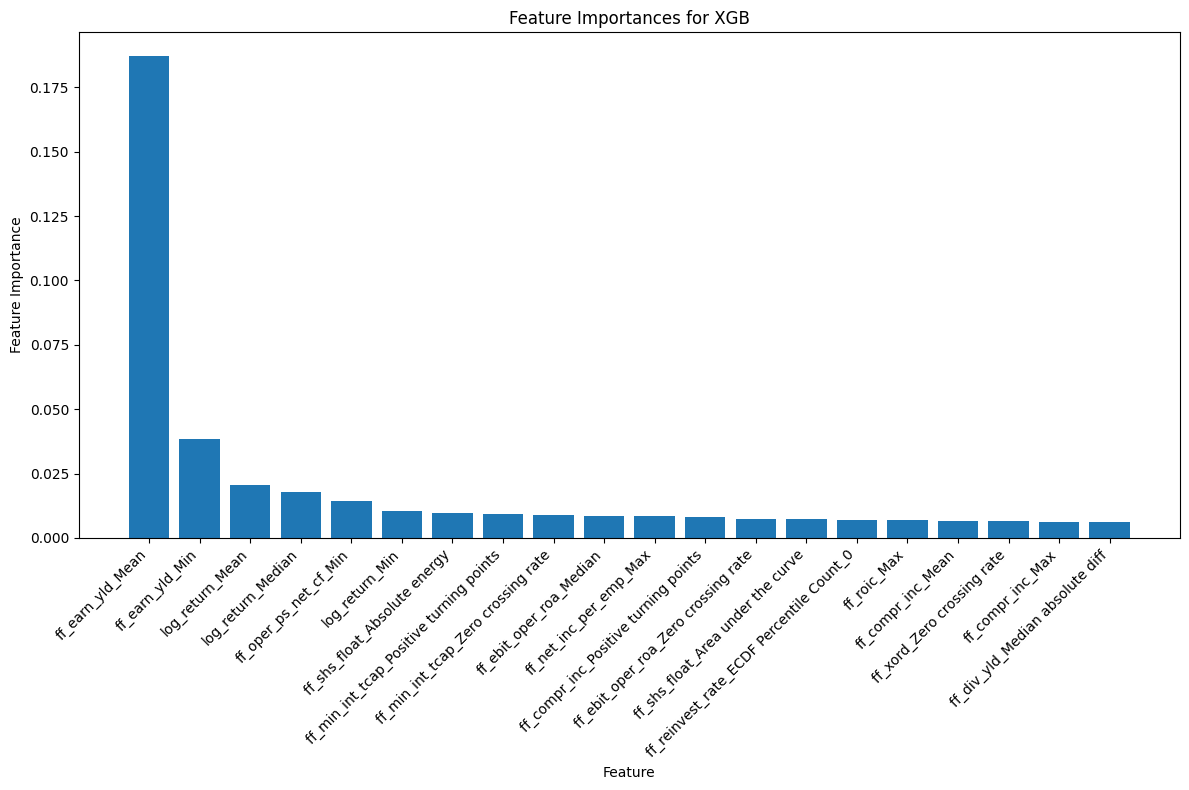

In [15]:
top_feats = feature_importances(model_loaded,feats, 'XGB')

Class imbalances: Train: 0.00492815703561997, Val: 0.009333508610490338,
          Test: 0.009021128432381103 
{0: 0.5045516250099816, 1: 55.425438596491226}
Estimate: 201.916
100%|██████████| 200/200 [04:29<00:00,  1.35s/trial, best loss: -0.3765922956836252] 
{'colsample_bytree': 0.74, 'eta': 0.125, 'gamma': 5.9, 'max_depth': 12.0, 'min_child_weight': 26.0, 'n_estimators': 673.0, 'scale_pos_weight': 366.30003908442353, 'subsample': 1.0}
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     12523
           1       0.18      0.54      0.27       114

    accuracy                           0.97     12637
   macro avg       0.59      0.76      0.63     12637
weighted avg       0.99      0.97      0.98     12637

MCC:  0.30531205089131835


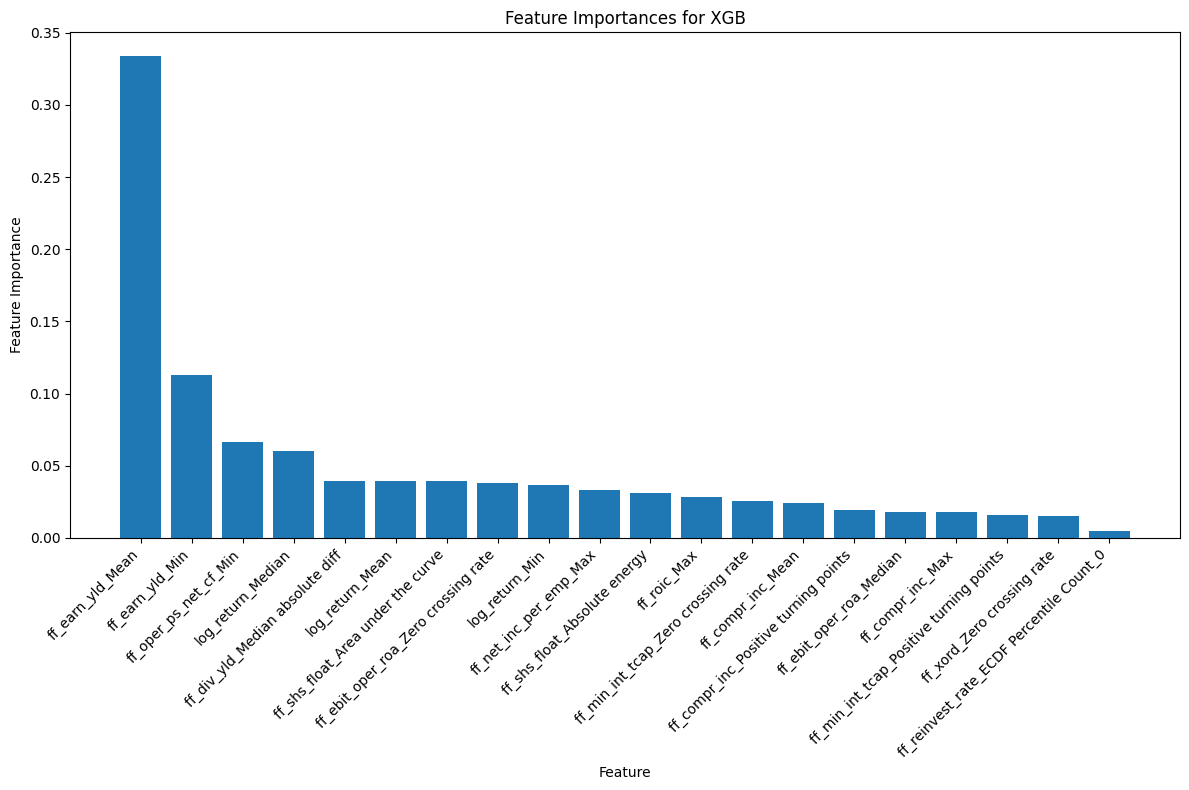

In [18]:
df2 = new_df[top_feats+['end_date', 'fsym_id', 'label']]
model2, feats2, X_test2, y_test2 = model_testing(df2, 'XGB')
top_feats2 = feature_importances(model2,feats2, 'XGB')

In [168]:

def time_series_cross_val(df, model):
    existing_model_params = model.get_params()
    new_model = xgb.XGBClassifier(**existing_model_params)
    tscv = TimeSeriesSplit(n_splits=5)
    exclude_columns = ['fsym_id', 'label', 'end_date']
    
    df=df.reset_index()
        
    df['end_date'] = pd.to_datetime(df['end_date'])# Initialize the preds column
    
    years = sorted(df['end_date'].dt.year.unique())
    print(years)
    
    pred_imploded_per_year = {}
    
    for i in range(len(years)-1):
        yr=years[i] 
        test_yr=years[i+1]
        pred_yr=test_yr+1 #the year the implosion is actually predicted to occur
        train_df = df[df['end_date'].dt.year<=yr]
        X_train= train_df.drop(exclude_columns, axis=1)
        y_train = train_df['label']
        
        test_df = df[df['end_date'].dt.year==test_yr]
        X_test= test_df.drop(exclude_columns, axis=1)
        y_test = test_df['label']
        
        new_model.fit(X_train, y_train)
        y_pred = new_model.predict(X_test)
        pred_imploded_per_year[pred_yr] = sum(y_pred==1)
        
    pred_imploded_df = pd.DataFrame(list(pred_imploded_per_year.items()), columns=['Year', 'Implosions'])
    df['year'] = df['end_date'].dt.year+1
    real_imploded_df = df.groupby('year')['label'].sum()
    real_imploded_df = pd.DataFrame({'Year': real_imploded_df.index, 'Implosions': real_imploded_df.values})
    real_imploded_df = real_imploded_df[real_imploded_df['Year'] >= 2005]
    
    print(pred_imploded_per_year)
    plt.figure(figsize=(12, 6))

    # Plot predicted implosions
    plt.plot(pred_imploded_df['Year'], pred_imploded_df['Implosions'], label='Predicted Implosions', marker='o')

    # Plot real implosions
    plt.plot(real_imploded_df['Year'], real_imploded_df['Implosions'], label='Real Implosions', marker='o')

    plt.xlabel('Year')
    plt.ylabel('Number of Implosions')
    plt.title('Predicted vs Real Implosions per Year')
    plt.legend()  # Show legend with labels
    plt.grid(True)  # Add grid lines
    plt.xticks(range(min(pred_imploded_df['Year']), max(pred_imploded_df['Year']) + 1))
    plt.show()
#     plt.figure(figsize=(12, 6))
#     sns.barplot(x='Year', y='Implosions', data=pred_imploded_df)
#     plt.xlabel('Year')
#     plt.ylabel('Number of Implosions')
#     plt.title('Number of Predicted Implosions per Year')
#     plt.show()
    
    
#     plt.figure(figsize=(12, 6))
#     sns.barplot(x='Year', y='Implosions', data=real_imploded_df)
#     plt.xlabel('Year')
#     plt.ylabel('Number of Implosions')
#     plt.title('Number of Real Implosions per Year')
#     plt.show()
    
    
        
#         X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
#         y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
#         new_model.fit(X_train, y_train)
#         preds = new_model.predict(X_test)
        
#         # Set the predictions in the result_df
#         result_df.iloc[test_index, -1] = preds  # -1 refers to the last column 'preds'
        
        # cm = confusion_matrix(y_test, preds, labels=new_model.classes_)
        # plt.figure(figsize=(8, 6))
        # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
        # plt.xlabel("Predicted")
        # plt.ylabel("Actual")
        # plt.title("Confusion Matrix")
        # plt.show()
        
# df_with_preds = time_series_cross_val(new_df, model_loaded)

In [37]:
agg_funcs = {
    'label': 'sum'  # Summing the 'label' column
}

mean_cols = [col for col in new_df.columns if col != 'label' and col != 'end_date' and col!='fsym_id']


for col in mean_cols:
    agg_funcs[col] = 'mean'  # Calculating mean for each column

stocks_df = new_df.drop('end_date',axis=1).groupby('fsym_id').agg(agg_funcs)

In [43]:
z_scores = (stocks_df['ff_earn_yld_Mean'] - stocks_df['ff_earn_yld_Mean'].mean()) / stocks_df['ff_earn_yld_Mean'].std()
threshold = 3
stocks_df = stocks_df[abs(z_scores) <= threshold]

In [50]:
# import seaborn as sns

# # Assuming 'df' is your DataFrame and 'column_name' is the name of the column you want to plot

# plt.figure(figsize=(10, 6))

# plt.boxplot([stocks_df[stocks_df['label'] == 0]['ff_earn_yld_Mean'], 
#                 stocks_df[stocks_df['label'] == 1]['ff_earn_yld_Mean']],
#                 labels=['Imploded', 'Non-Imploded'], vert=False, notch=True, patch_artist=True)

# plt.xlabel('Label')  # Label for x-axis
# plt.ylabel('Earnings Yields (Mean)')  # Label for y-axis
# plt.title('Boxplot of Earnings Yields (Non-Implosion Years vs Implosion Years)')  # Title of the plot
# plt.grid(True)  # Show grid
# plt.legend()  
# plt.savefig('results_5yr/earn_ylds_boxplot.png')# Show legend
# plt.show()


## MLP Training

In [11]:
from hyperopt import hp, fmin, tpe, Trials
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from hyperopt.early_stop import no_progress_loss
from sklearn.metrics import matthews_corrcoef, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Define the search space for hyperparameters

def hyperopt_nn(df):
    seed = 42
    df = df.set_index('end_date')
    df = df.sort_index()
    exclude_columns = ['fsym_id', 'label']
    train_df = df[df.index < '2019-01-01']
    test_df = df[df.index >= '2019-01-01']
    
    X_train = train_df.drop(exclude_columns, axis=1)
    y_train = train_df['label']
    
    X_test = test_df.drop(exclude_columns, axis=1)
    y_test = test_df['label']
    
    feats = X_train.columns
    
    space = {
        'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
        'batch_size': hp.choice('batch_size', [1024, 2048, 4096]),
        'num_layers': hp.choice('num_layers', [2, 3, 4, 5, 6]),
        'num_neurons': hp.choice('num_neurons', [128, 256, 512, 1024, 2048, 4096]),
        'dropout_rate': hp.uniform('dropout_rate', 0, 0.5),
        'class_weight_0': hp.uniform('class_weight_0', 0.1, 5),  
        'class_weight_1': hp.uniform('class_weight_1', 0.1, 200) 
    }

    scaler=StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train_df = pd.DataFrame(X_train, columns=feats)
    X_test_df = pd.DataFrame(X_test, columns=feats)
    # class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    # class_weight_dict = dict(enumerate(class_weights))
    # print(class_weight_dict)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    # tscv = TimeSeriesSplit(n_splits=2)
    
    def time_series_cross_validation(params):
        # Define the number of splits

        metrics = []  # Store metrics for each fold
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Flatten(input_shape=(X_train.shape[1],)))

        for _ in range(params['num_layers']):
            model.add(tf.keras.layers.Dense(params['num_neurons'], activation='relu'))
            model.add(tf.keras.layers.Dropout(params['dropout_rate']))

        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

#         for train_index, val_index in tscv.split(X):
#             X_train, X_val = X[train_index], X[val_index]
#             y_train, y_val = y[train_index], y[val_index]

#               # Define your model creation function

#             optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
#             model.compile(optimizer=optimizer, loss='binary_crossentropy')

#             class_weight_dict = {0: params['class_weight_0'], 1: params['class_weight_1']}
#             hist = model.fit(X_train, y_train, batch_size=params['batch_size'], epochs=10, class_weight=class_weight_dict, callbacks=[early_stopping], verbose=0)

#             preds = model.predict(X_val, batch_size=params['batch_size'], verbose=0)
#             preds = np.where(preds >= 0.5, 1, 0)

#             metric = matthews_corrcoef(y_val, preds)
#             metrics.append(metric)
        optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
        model.compile(optimizer=optimizer, loss='binary_crossentropy')

        class_weight_dict = {0: params['class_weight_0'], 1: params['class_weight_1']}
        hist = model.fit(X_train, y_train, batch_size=params['batch_size'], epochs=10, class_weight=class_weight_dict, callbacks=[early_stopping], verbose=0)

        preds = model.predict(X_test, batch_size=params['batch_size'], verbose=0)
        preds = np.where(preds >= 0.5, 1, 0)

        metric = matthews_corrcoef(y_test, preds)
        metrics.append(metric)
        # obj_scores.append(scores.mean())
        return model, metric

        # return model, sum(metrics)/len(metrics)

    def train_with_params(params):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Flatten(input_shape=(X_train.shape[1],)))

        for _ in range(params['num_layers']):
            model.add(tf.keras.layers.Dense(params['num_neurons'], activation='relu'))
            model.add(tf.keras.layers.Dropout(params['dropout_rate']))

        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

        optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
        model.compile(optimizer=optimizer, loss='binary_crossentropy')

        class_weight_dict = {0: params['class_weight_0'], 1: params['class_weight_1']}
        hist = model.fit(X_train, y_train, batch_size=params['batch_size'], epochs=10, class_weight = class_weight_dict, callbacks = [early_stopping], verbose=0)
        preds = model.predict(X_test, batch_size=params['batch_size'], verbose=0 )
        for i in range(len(preds)):
            preds[i] = 1 if preds[i] >=0.5 else 0
            
        metric = matthews_corrcoef(y_test, preds)
        return model, metric
    
    
    def objective(params):
        model, metric = time_series_cross_validation(params)
        return -metric



    # Run hyperparameter optimization
    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)
    
    activation_map = {0: 'relu', 1: 'sigmoid'}
    best_hyperparams = {
        'learning_rate': best['learning_rate'],
        'batch_size': [1024, 2048, 4096, 8192][best['batch_size']],
        'num_layers': [2, 3, 4, 5, 6][best['num_layers']],
        'num_neurons': [128, 256, 512, 1024, 2048, 4096][best['num_neurons']],
        'dropout_rate': best['dropout_rate'],
        'class_weight_0': best['class_weight_0'],
        'class_weight_1': best['class_weight_1']
    }

    print("Best hyperparameters:", best_hyperparams)
    best_model, best_metric = train_with_params(best_hyperparams)
    print(f'Best metric: {best_metric}')
    preds = best_model.predict(X_test, batch_size = best_hyperparams['batch_size'])
    print(preds)
    for i in range(len(preds)):
        preds[i] = 1 if preds[i] >= 0.5 else 0
    final_report = classification_report(y_test, preds)
    mcc = matthews_corrcoef(y_test, preds)
    
    write_results(final_report, mcc, best_hyperparams, f'results_5yr/MLP_report')
            
    return best_model, X_train_df, X_test_df
    
model, X_train, X_test = hyperopt_nn(new_df)


100%|██████████| 50/50 [21:59<00:00, 26.38s/trial, best loss: -0.24736154017323492]
Best hyperparameters: {'learning_rate': 0.00010143142719358479, 'batch_size': 2048, 'num_layers': 4, 'num_neurons': 1024, 'dropout_rate': 0.2895459494212776, 'class_weight_0': 4.683732277921654, 'class_weight_1': 73.25898494090654}
Best metric: 0.22261137791719654
7/7 [==============================] - 0s 16ms/step
[[2.9737288e-03]
 [2.8579956e-04]
 [6.4025528e-07]
 ...
 [7.8001700e-04]
 [2.6324929e-03]
 [5.0298695e-04]]


## SHAP Values

 99%|===================| 12534/12637 [00:17<00:00]        

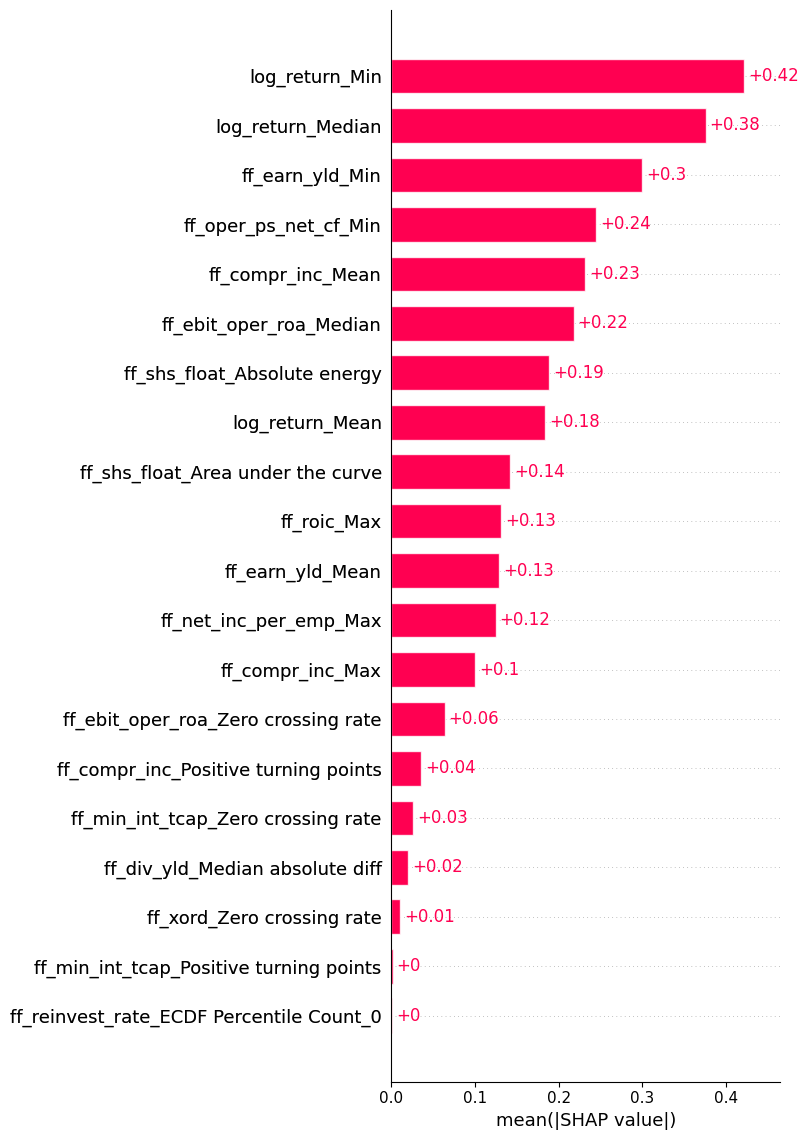

<Figure size 640x480 with 0 Axes>

In [185]:
import shap


def shapley(df, model, model_name, plot_type):
    exclude_columns = ['fsym_id', 'label', 'end_date']
    train_df = df[df['end_date'] < '2019-01-01']
    test_df = df[df['end_date'] >= '2019-01-01']
    
    X_train = train_df.drop(exclude_columns, axis=1)
    y_train = train_df['label']
    
    X_test = test_df.drop(exclude_columns, axis=1)
    y_test = test_df['label']
    
    explainer = shap.Explainer(model,X_train)
    shap_values = explainer(X_test)
    shap.initjs()
    # print(shap_values.shape)
    # shap.plots.beeswarm(shap_values)
    # shap.summary_plot(shap_values,test,show=False)
    if plot_type == 'bar':
        shap.plots.bar(shap_values, max_display=20, show=False)
    elif plot_type == 'beeswarm':
        shap.plots.beeswarm(shap_values, max_display=20, show=False)
        
    plt.tight_layout()
    plt.show()
    plt.savefig(f'results_5yr/{model_name}_shap_{plot_type}_top20.png')
    
    
shapley(df2, model2, model_name='XGB', plot_type = 'bar')
# shapley(model, X_train, X_test, 'XGB', 'beeswarm')

## False Positives/Negatives

In [47]:
from CreateDataset import get_fund_data
import math
from datetime import timedelta

def plotting_stocks_pandas(model, df):
    df = df.set_index('end_date')
    df = df.sort_index()
    exclude_columns = ['fsym_id', 'label']
    test_df = df[df.index >= '2019-01-01']
    
    X_test = test_df.drop(exclude_columns, axis=1)
    y_test = test_df['label']
    
    preds = model.predict(X_test)
    test_df['preds'] = preds
    
    
    imploded_stocks = test_df[(test_df['label'] == 1) & (test_df['preds'] == 0)]
    spark_df = spark.createDataFrame(imploded_stocks['fsym_id'].to_frame())
    imp_prices = get_fund_data(spark_df)
    
    adj_pd = imp_prices.toPandas()
    adj_pd['date'] = pd.to_datetime(adj_pd['date'])
    list_to_plot = sorted(adj_pd['fsym_id'].unique().tolist())[:24]
    
    columns = 8
    num_rows = math.ceil(len(list_to_plot) / columns)
    fig, axs = plt.subplots(nrows=num_rows, ncols=columns, figsize=(35, 5*num_rows))
    axs = axs.flatten()
    
    i = 0
    for t in list_to_plot:
        temp_df = adj_pd[adj_pd['fsym_id']==t]
        impl_period = imploded_stocks[imploded_stocks['fsym_id']==t]
        impl_period = impl_period.reset_index()
        impl_period = impl_period.iloc[0]
        # print(impl_period)
        axs[i].plot(temp_df['date'], temp_df['adj_price'], label=t)
        axs[i].axvspan(pd.to_datetime(impl_period['end_date']), pd.to_datetime(impl_period['end_date'])+timedelta(weeks=52), alpha=0.5, color='red')
        axs[i].legend()
        #axs[i].text(0.5, -0.1, f'Volatility: {vol:.2f}', ha='center', transform=axs[i].transAxes)
        i+=1
        
    for i in range(len(list_to_plot), num_rows * columns):
        fig.delaxes(axs.flatten()[i])
    
        
    plt.tight_layout()
    plt.savefig('results_5yr/incorrect_implosions_detected_by_model.png')
    
# plotting_stocks_pandas(model_loaded, new_df)

# Scrapped Code
Some of these functions may still be useful

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras import layers



def plot_model_performance(mdl, loss, metric):
    x = pd.DataFrame(mdl.history).reset_index()
    x = pd.melt(x, id_vars='index')
    x['validation'] = (x['variable'].str[:4] == 'val_').replace({True:'validation',False:'training'})
    x['loss'] = (x['variable'].str[-4:] == 'loss').replace({True:loss,False:metric})
    g = sns.FacetGrid(x, col='loss', hue='validation',sharey=False)
    g.map(sns.lineplot, 'index','value')
    g.add_legend()
    return g

def nn_training(df):
    train_df, test_df = t_t_split(df)

    train_df = train_df.toPandas()
    train_df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Drop rows containing NaN values
    train_df.dropna(axis=0, how='any', inplace=True)
    
    test_df = test_df.toPandas()
    train_X = train_df.drop(['fsym_id', 'label'], axis=1).values
    train_y = np.array(train_df['label'])
    test_X = test_df.drop(['fsym_id', 'label'], axis=1).values
    test_y = np.array(test_df['label'])
    print(np.sum(test_y==1))
    print(train_X, train_y)
    
    class_labels = np.unique(train_y)
    class_weights = compute_class_weight('balanced', classes=class_labels, y=train_y.flatten())
    class_weight_dict = dict(zip(class_labels, class_weights))
    print(class_weight_dict)
    

    # Define the neural network model
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(train_X.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),  # Additional Dense layer
        tf.keras.layers.Dropout(0.5),  # Dropout layer for regularization
        tf.keras.layers.Dense(16, activation='relu'),  # Another Dense layer
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # model = keras.Sequential()
    # model.add(layers.Dense(16,activation="relu",input_shape=(train_X.shape[1],)))
    # model.add(layers.Dense(8,activation="tanh"))
    # model.add(layers.Dense(1))


    # Compile the model
    loss_fn = keras.losses.BinaryCrossentropy()
    optimizer = keras.optimizers.Adam(
        learning_rate=0.001
    )

    
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

    # Train the model
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    fit_model = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_split=0.1, class_weight = class_weight_dict)
    plot_model_performance(fit_model, 'bin_cross_entropy','accuracy')

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_X, test_y)
    print(f'Test accuracy: {test_acc}')

    # Make predictions on new data
    predictions = model.predict(test_X)
    for i in range(len(predictions)):
        predictions[i] = 1 if predictions[i] >= 0.5 else 0
    print(classification_report(predictions, test_y.flatten()))
    
    # pred_df = pd.DataFrame()
    # pred_df['prediction'] = predictions
    # pred_df['label'] = test_y
    # confusion_matrix_pandas(pred_df)
    cm = confusion_matrix(test_y, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

nn_training(df)

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import when, lit, col
# import pyspark.pandas as ps
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import csv


def pct_change_df(df, big_string, table):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    
    query1 = f"""
                SELECT t.fsym_id, t.Implosion_Start_Date, b.date, {big_string}
                FROM temp_table t
                LEFT JOIN sym_ticker_region s ON s.fsym_id = t.fsym_id
                LEFT JOIN {table} a ON s.fsym_id = a.fsym_id AND  YEAR(a.date) = YEAR(t.Implosion_Start_Date)
                LEFT JOIN {table} b ON s.fsym_id = b.fsym_id AND  YEAR(b.date) = YEAR(t.Implosion_Start_Date)-1
                ORDER BY t.fsym_id
            """
    df1 = spark.sql(query1)
    #print(df1.show())
    df1 = df1.toPandas()
    df1 = df1.drop(['fsym_id','Implosion_Start_Date','date'], axis=1)
    
    def remove_outliers(column):
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return column[(column >= lower_bound) & (column <= upper_bound)]



    df1 = df1.abs()
    null_percentage = df1.isnull().sum() / len(df1)
    columns_to_keep = null_percentage[null_percentage <= 0.3].index
    df_nulls_removed = df1[columns_to_keep]
    print("Columns kept: ", len(columns_to_keep)/len(df1.columns))
    
    df_no_outliers = df_nulls_removed.apply(remove_outliers)

    
    column_means_no_outliers = df_no_outliers.mean()
    #column_means_no_outliers = column_means_no_outliers.dropna()
    column_means_no_outliers = column_means_no_outliers.sort_values()
    feats = column_means_no_outliers.tail(5)

    print("Largest averages of differences between previous year and implosion year: ",feats)
    return feats.index.tolist()
    
def avg_change_df(df, big_string, table):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    
    query1 = f"""
                SELECT t.fsym_id, {big_string}
                FROM temp_table t  
                LEFT JOIN sym_ticker_region s ON s.fsym_id = t.fsym_id
                LEFT JOIN {table} a ON s.fsym_id = a.fsym_id AND  YEAR(a.date) > YEAR(t.Implosion_Start_Date)
                LEFT JOIN {table} b ON s.fsym_id = b.fsym_id AND  YEAR(b.date) < YEAR(t.Implosion_Start_Date)
                GROUP BY t.fsym_id
                ORDER BY t.fsym_id
            """
    df1 = spark.sql(query1)
    df1 = df1.toPandas()
    df1 = df1.drop(['fsym_id'], axis=1)
    
    def remove_outliers(column):
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return column[(column >= lower_bound) & (column <= upper_bound)]


    df1 = df1.abs()
    null_percentage = df1.isnull().sum() / len(df1)
    columns_to_keep = null_percentage[null_percentage <= 0.3].index
    df_nulls_removed = df1[columns_to_keep]
    print("Columns kept: ", len(columns_to_keep)/len(df1.columns))
    
    df_no_outliers = df_nulls_removed.apply(remove_outliers)
    
    column_means_no_outliers = df_no_outliers.mean()
    #column_means_no_outliers = column_means_no_outliers.dropna()
    column_means_no_outliers = column_means_no_outliers.sort_values()
    feats = column_means_no_outliers.tail(5)
    print("Largest averages of differences in average before and after implosion date: ", feats)
#     for feature in feats.index:
#         before_implosion = df_no_outliers[feature][df_no_outliers.index.isin(df1[df1[feature].notnull() & (df1['date'] < df1['Implosion_Start_Date'])].index)]
#         after_implosion = df_no_outliers[feature][df_no_outliers.index.isin(df1[df1[feature].notnull() & (df1['date'] > df1['Implosion_Start_Date'])].index)]
        
#         _, p_value = ttest_ind(before_implosion, after_implosion)
        
#         print(f"T-test p-value for {feature}: {p_value}")
    return feats.index.tolist()

def t_test():
    pass


def get_metric_changes(filename, table):
    df = pd.read_csv(filename, index_col=False)
    df = df[df['Implosion_Start_Date'].notnull()]
    df['Implosion_Start_Date'] = pd.to_datetime(df['Implosion_Start_Date']).dt.date
    df['Implosion_End_Date'] = pd.to_datetime(df['Implosion_End_Date']).dt.date
    cols = get_not_null_cols(df, table)
    result_string = ', '.join('(a.' + item + '-b.' + item +')/b.'+item + ' AS ' + item for item in cols)
    feats1 = pct_change_df(df, result_string, table) #change 1 year before
    print("Features with greatest percentage change with year before implosion: ", feats1)
    
    result_string2 = ', '.join('(MEAN(a.' + item + ')-MEAN(b.' + item +'))/MEAN(b.'+item + ') AS ' + item for item in cols)
    feats2 = avg_change_df(df, result_string2, table)
    print("Features with greatest percentage change in mean before and after implosion", feats2)
    
    write_features_file( list(set(feats1+feats2)) )


get_metric_changes('imploded_stocks_price.csv', 'FF_ADVANCED_DER_AF')


### Correlations with Market Value Returns

In [ ]:
import csv
from CreateDataset import get_feature_col_names, get_fund_data


def corr_query(implosion_df, col_string, table): 
    df = get_fund_data(implosion_df)
    df=df.withColumn('year', F.year('date'))
    window_spec = Window.partitionBy('fsym_id', 'year').orderBy(col('date').desc())

    df = df.withColumn('row_num', F.row_number().over(window_spec))

    df = df.filter(col('row_num') == 1).orderBy('date') #should we compare correlations with market val?
    #should we do quarterly?
    
    df.createOrReplaceTempView("temp_table")
    query1 = f"""
                SELECT t.fsym_id, t.adj_price, t.Market_Value, t.date, {col_string}
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id AND YEAR(t.date)=YEAR(a.date)
                ORDER BY t.fsym_id, t.date
            """
 
    q_df = spark.sql(query1)
    #q_df.show()
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    
    q_df = q_df.withColumn("return_market_val", (F.col('Market_Value') - F.lag('Market_Value').over(window_spec)) / F.lag('Market_Value').over(window_spec))
    q_df = q_df.withColumn("return", (F.col('adj_price') - F.lag('adj_price').over(window_spec)) / F.lag('adj_price').over(window_spec))
    
    return_columns = [c[2:] for c in col_string.split(", ")]
    mean_corrs = []
    corr_vals = []
    #I THINK U NEED TO GROUP BY DATE AND THEN CALCULATE CORRELATIONS

    for column in return_columns:
        return_col_name = f"return_{column}"
        corr_col_name = f"corr_with_{column}"
        q_df = q_df.withColumn(return_col_name, (F.col(column) - F.lag(column).over(window_spec)) / F.lag(column).over(window_spec))
        q_df = q_df.withColumn(column, F.corr(return_col_name, 'return_market_val').over(window_spec)) #calculating correlations with market value return
        q_df = q_df.drop(*[return_col_name])
    q_df = q_df.drop(*['return_market_val', 'return'])
    q_df = q_df.select(q_df.columns[4:])
    mean_corrs = q_df.agg(*[F.mean(F.abs(F.col(column))).alias(column) for column in q_df.columns])
    # mean_corrs.show()
    
    return mean_corrs.toPandas()

def corr_analysis(table):
    imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
    imp_df_price = imp_df_price.loc[imp_df_price['Implosion_Start_Date'].notnull()]
    cols = get_not_null_cols(imp_df_price, 'FF_ADVANCED_DER_AF')
    result_string = ', '.join('a.' + item for item in cols)
    mean_corrs_df = corr_query(spark.createDataFrame(imp_df_price), result_string, 'FF_ADVANCED_DER_AF')
    mean_corrs = mean_corrs_df.to_dict(orient='records')
    sorted_corrs = dict(sorted(mean_corrs[0].items(), key=lambda item: item[1], reverse=True))
    top_records = list(sorted_corrs.items())[:5]
    top_10 = []
    for r in top_records:
        top_10.append(r[0])
    print(top_10)
    current_feature_list = get_feature_col_names()
    new_feature_list = list(set(current_feature_list + top_10))
    
    write_features_file(new_feature_list)
    
    
corr_analysis('FF_Advanced_Der_AF')

### Adding the Extra Features From Literature

In [ ]:
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_price['Implosion_Start_Date'] = pd.to_datetime(imp_df_price['Implosion_Start_Date'])
imp_df_price['Implosion_End_Date'] = pd.to_datetime(imp_df_price['Implosion_End_Date'])
available_feats = get_not_null_cols(imp_df_price)
extra_feats = ['ff_capex_assets', 'ff_gross_cf_debt', 'ff_mkt_val_gr']

current_feats = get_feature_col_names()
final_feats = list(set(current_feats + extra_feats))
write_features_file(final_feats)

### Boruta

In [ ]:
def get_df(all_feats=False, imploded_only=False):
    df = get_tabular_dataset(all_feats=all_feats, imploded_only=imploded_only)
    df = forward_fill(df)
    print("Number of rows: ", df.count())
    print("Number of positives: ", df.filter(F.col('label')==1).count())
    df=df.fillna(0.0)
    print("Number of rows after dropping nulls: ", df.count())
    print("Number of positives after dropping nulls: ", df.filter(F.col('label')==1).count())
    return df


def forward_fill(df):
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    feature_cols = df.columns[2:-1]
    for c in feature_cols:
        df = df.withColumn(
            c, F.last(c, ignorenulls=True).over(window_spec)
        )
    return df.orderBy('fsym_id','date')

df = get_df()


In [ ]:
from Boruta import BorutaPy
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


def boruta_fs(train_df, model_name): #HOW DOES BORUTA ACC WORK?
    train_df = train_df.toPandas()
    X_train = train_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_train = train_df['label']
    
    if model_name == 'rf':
        model = RandomForestClassifier()
    else:
        model = GradientBoostingClassifier
    feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1)
    feat_selector.fit(X_train, y_train)
    features = X_train.columns.tolist()
    print("Number of features: ", len(features) )
    feature_ranks = list(zip(features, feat_selector.ranking_, feat_selector.support_))
    selected_features = []
    for feat in feature_ranks:
        print(f"Feature: {feat[0]}, Rank: {feat[1]}, Keep: {feat[2]}")
        if feat[1] <= 5:
            selected_features.append(feat[0])
    print("Selected features: ", selected_features)
    return selected_features

rf_feats = boruta_fs(df, 'rf')
gbt_feats = boruta_fs(df, 'gbt')

In [ ]:
# current_features = get_feature_col_names()
# for f in boruta_features:
#     if f in current_features:
#         print(f)
# final_features = list(set(boruta_features + current_features))
# write_features_file(final_features) #in the feature selection pipeline, 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def correlation_matrix(df):
    df =df.toPandas()
    print("Converted to Pandas")
    corr_df = df.drop(['date','fsym_id'], axis=1)
    corr_mat = corr_df.corr()
    mask = np.triu(np.ones_like(corr_mat))
    plt.figure(figsize=(50, 40))
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    # plt.savefig('corr_matrix.png')
    plt.close()
    
    print("Variable pairs with absolute correlation above 0.7:")
    for i in range(len(corr_mat.columns)):
        for j in range(i+1, len(corr_mat.columns)):
            if abs(corr_mat.iloc[i, j]) >= 0.7:
                print(f"{corr_mat.columns[i]} - {corr_mat.columns[j]}: {corr_mat.iloc[i, j]}")
                
# correlation_matrix(train_df)

In [ ]:
df = df.drop('ff_div_yld_secs', 'ff_earn_yld', 'ff_roa_ptx', 'ff_net_inc_basic_aft_xord', 'ff_net_inc_dil', 'ff_oper_inc_aft_unusual', 
                        'ff_net_inc_dil_aft_xord', 'ff_net_inc_dil_bef_unusual', 'ff_ebit_bef_unusual', 'ff_eps_dil_gr', 'GDP', 'ff_bk_oper_inc_tot')
feats = df.columns[2:-1]
# write_features_file(feats)
feats

### Extra

In [ ]:
def start_dates(imp_df_price):
    price_data = get_fund_data(spark.createDataFrame(imp_df_price))
    #cols = get_not_null_cols(imp_df_price, 'FF_ADVANCED_DER_AF')
    #result_string = ', '.join('a.' + item for item in cols)
    
    window_spec = Window.partitionBy('fsym_id').orderBy(col('p_date'))

    price_data = price_data.withColumn('row_num', F.row_number().over(window_spec))
    price_data.show()

    price_data = price_data.filter(col('row_num') == 1).orderBy(col('p_date').desc())
    price_data.show()
    
    start_dates = price_data.groupBy('year').count().orderBy('year')
    years = [row['year'] for row in start_dates.collect()]
    counts = [row['count'] for row in start_dates.collect()]
    plt.bar(years, counts)
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title('Start Dates Count per Year')
    plt.show()
    #start_dates.show(25)
    
def null_vals(imp_df_price, table):
    price_data = get_fund_data(spark.createDataFrame(imp_df_price))
    cols = get_not_null_cols(imp_df_price, table)
    col_string = ', '.join('a.' + item for item in cols)
    price_data.createOrReplaceTempView('temp_table')
    null_counts = []
    query1 = f"""
                SELECT t.fsym_id, t.split_adj_price, t.Market_Value, t.p_date, {col_string}
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id AND YEAR(t.p_date)=YEAR(a.date)
                ORDER BY t.fsym_id, t.p_date
            """
    full_df = spark.sql(query1)
    for column in cols:
        null_count = full_df.select(column).filter(col(column).isNull()).count()
        null_counts.append((column, null_count))
    null_counts_df = pd.DataFrame(null_counts, columns=['Column', 'Null Count'])
    plt.figure(figsize=(10, 6))
    plt.bar(null_counts_df['Column'], null_counts_df['Null Count'])
    plt.xlabel('Column')
    plt.ylabel('Null Count')
    plt.title('Null Counts for Each Column')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    # null_counts = price_data.groupBy('year').agg(F.sum(col('p_price').isNull().cast('int')).alias('null_count'))
    # null_counts.show()
    
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_price_imploded = imp_df_price.loc[imp_df_price['Implosion_Start_Date'].notnull()]
start_dates(imp_df_price)
start_dates(imp_df_price_imploded)

#null_vals(imp_df_price, 'FF_ADVANCED_DER_AF')

In [ ]:
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_test = imp_df_price[imp_df_price['fsym_id']=='H7CTYF-R']
df = get_fund_data(spark.createDataFrame(imp_df_test))
df.show(1000)
imp_df_imp = imp_df_price[imp_df_price['Implosion_Start_Date'].notnull()]
print(len(imp_df_imp))

In [ ]:
imp_df_imp = imp_df_price[imp_df_price['Implosion_Start_Date'].notnull()]
print(len(imp_df_imp))
print(len(imp_df_price))

In [ ]:
def get_cols():
    df_metrics = ps.DataFrame(spark.sql("SELECT * FROM FF_BASIC_AF LIMIT 10")) #get all the metrics
    cols = []
    for c in df_metrics.columns:
        if df_metrics[c].dtype=='float64':#get all the metrics we can calculate correlations with
            cols.append(c)
    return cols

#%change average of each feature plotted for pharmacy industry
def industry_analysis():
    stock_df = get_all_stocks_df()
    #stock_df = pd.read_csv('imploded_stocks.csv')
    #stock_df = spark.createDataFrame(stock_df)
    cols = ['ff_gross_inc', 'ff_sales', 'FF_OPER_EXP_TOT', 'FF_CASH_ST']
    col_string = ', '.join('a.' + item for item in cols)
    stock_df.createOrReplaceTempView("temp_table")
    q = f"""SELECT e.factset_industry_desc, t.ticker_region, a.date, {col_string} FROM temp_table t
    LEFT JOIN FF_BASIC_AF a ON a.fsym_id = t.fsym_id
    LEFT JOIN sym_coverage sc ON sc.fsym_id = t.fsym_id
    LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
    LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
    LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code
    WHERE a.date >= "2009-01-01" AND e.factset_industry_desc="Regional Banks"
    ORDER BY t.ticker_region,a.date"""
    ind_df = spark.sql(q)
    #print(ind_df.show(10))
    ind_df =ind_df.toPandas()
    ind_df['date'] = pd.to_datetime(ind_df['date'])
    new_cols = []
    for column in cols:
        ind_df[f'{column}_percentage_change'] = ind_df.groupby('ticker_region')[column].pct_change() * 100
        ind_df[f'{column}_percentage_change'].replace([np.inf, -np.inf], np.nan, inplace=True)
        ind_df.drop(column, axis=1, inplace=True)
        new_cols.append(f'{column}_percentage_change')
    ind_df['year'] = ind_df['date'].dt.year
    avg_pct_change = ind_df.groupby(['year'])[new_cols].mean().reset_index()
    print(avg_pct_change.head(20))
    num_rows = (len(new_cols) + 1) // 2  # Adjust the number of rows as needed
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    for i,column in enumerate(new_cols):
        row = i//num_cols
        col = i % num_cols 
        axes[row,col].plot(avg_pct_change['year'], avg_pct_change[column])
        axes[row, col].set_title(f'Avg {column} Percentage Change Over Time')
        axes[row, col].set_xlabel('Year')
        axes[row, col].set_ylabel(f'Avg {column} Percentage Change')
        axes[row, col].grid(True)
    plt.tight_layout()
    plt.show()

#industry_analysis()

In [ ]:
def get_not_null_cols(df, table='FF_ADVANCED_DER_AF'):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    query1 = f"""SELECT t.fsym_id, a.*
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id
                ORDER BY t.fsym_id, a.date
            """
    #we get all the available dates per stock, so these null values are only within the timeframe available
    q_df = spark.sql(query1)
    column_types = q_df.dtypes
    null_pcts = []
    for c, dtype in zip(q_df.columns, column_types):
        if dtype[1] == 'double':
            null_count = q_df.filter(F.col(c).isNull()).count()
            null_pcts.append(null_count/q_df.count())


    columns_to_drop = [col_name for col_name, null_pct, dtype in zip(q_df.columns, null_pcts, column_types) if null_pct > 0.2 or dtype[1]!='double']

    q_df = q_df.drop(*columns_to_drop)

    cols = q_df.columns
    print(cols)

    return cols
    
df = pd.read_csv('imploded_stocks_price.csv', index_col=False)
df = df.loc[df['Implosion_Start_Date'].notnull()]
get_not_null_cols(df)

In [ ]:
spark.stop()